# dev for Getting intersections of curves in numpy

In [38]:
#pylab
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pylab import imshow, show

import skimage as sk
from skimage import measure, filters

import matplotlib.pyplot as plt, numpy as np, os
from numba import njit, jit, vectorize
from PIL import Image
import imageio
# import cv2 as cv

#automate the boring stuff
from IPython import utils
import time, os, sys, re
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()
width = 512
height = 512
channel_no = 3

# #load the libraries
from lib import *
# from lib.operari import *
# from lib.ProgressBar import *
# from lib.minimal_model import *
# from lib.TexturePlot import *
# from lib.get_tips import *
# from lib.minimal_model import *
# from lib.intersection import *


# #load the measrue library for robust, simplified, fast tip detection
# from lib.measure import find_contours
# from lib.measure._utils_find_contours import *
# from lib.measure._utils_find_tips import *
# from lib.measure._find_tips import *

#use cuda via numba
from numba import jit, njit, vectorize, cuda, uint32, f8, uint8
from numba.typed import List
# from lib.contours_to_tips import *

%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### runtime speedtest results

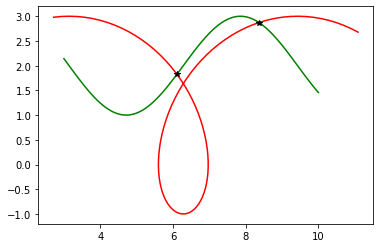

In [6]:
a, b = 1, 2
phi = np.linspace(3, 10, 100)
x1 = a*phi - b*np.sin(phi)
y1 = a - b*np.cos(phi)

x2=phi
y2=np.sin(phi)+2
tips = intersection(x1,y1,x2,y2)
x,y = tips

plt.plot(x1,y1,c='r')
plt.plot(x2,y2,c='g')
plt.plot(x,y,'*k')
plt.show()

- without numba = 3.34 seconds

In [ ]:
%time
tips = intersection(x1,y1,x2,y2)

# create figures for intersection algorithm
- written completely in numpy
- input types work with numba.njit or numba.cuda.jit when using tuple(contours_a or b)

In [ ]:
S1, S2, S3, S4 = _rect_inter_inner(x1, x2)
S5, S6, S7, S8 = _rect_inter_inner(y1, y2)

In [ ]:
fig, axs = plt.subplots(2,4)#,figsize=(8,4))
a = list(axs[0])
a.extend(list(axs[1]))
S_lst = (S1,S2,S3,S4,S5,S6,S7,S8)
for n,ax,S in list(zip(range(len(S_lst)), a, S_lst)):
#     print(ax)
    ax.imshow(S)
    ax.axis('off')
    ax.set_title(f'$S{n+1}$')
fig.savefig('Figures/fast_intersection_coordinates.svg')

In [ ]:
C1 = np.less_equal(S1, S2)
C2 = np.greater_equal(S3, S4)
C3 = np.less_equal(S5, S6)
C4 = np.greater_equal(S7, S8)

fig, axs = plt.subplots(1,4)#,figsize=(8,4))
# a = list(axs[0])
# a.extend(list(axs[1]))
a = axs
S_lst = (C1,C2,C3,C4)
for n,ax,S in list(zip(range(len(S_lst)), a, S_lst)):
#     print(ax)
    ax.imshow(S)
    ax.axis('off')
    ax.set_title(f'$C{n+1}$')
fig.savefig('Figures/fast_intersection_booleans.pdf')

In [ ]:
a, b = 1, 2
phi = np.linspace(3, 10, 100)
x1 = a*phi - b*np.sin(phi)
y1 = a - b*np.cos(phi)

x2=phi
y2=np.sin(phi)+2
tips = intersection(x1,y1,x2,y2)
x,y = tips
plt.figure(figsize=(4,4))
plt.plot(y1,x1,c='r')
plt.plot(y2,x2,c='g')
plt.plot(y,x,'*b')
plt.axis('off')
# plt.show()
plt.savefig('Figures/fast_intersection_example.svg')

# Don't spend time on this: make/test rotate function for exception handling in intersect()
_application: retry funny intersection calls with a 45º rotation_<br>
if intersections(x) fails:
    return $R^{-1}\text{intersections}(X)R$ for rotation by pi/4 in out-of-plane axis<br>
`scipy.ndimage.rotate(input, angle, axes=(1, 0), reshape=True, output=None, order=3, mode='constant', cval=0.0, prefilter=True)`

In [293]:
print(padded_txt.shape)
print(dtexture_dt.shape)

(1024, 1024)
(512, 512, 3)


# make intersection enforce pbc!!
- DONE: Make a naive padded texture that enforces periodic boundary conditions
- DONE: get tips = intersection(padded_texture)
- DONE: map tips to original xy coordinates.  do they agree?
- DONE: remove duplicate tips
- DONE: ^put all that into a function and test it

In [9]:
#Make a naive padded texture that enforces periodic boundary conditions
txt = np.load(f'Data/buffer_chaos_circle6_sigma_5_threshold_0.6_wrapping_true_at_time_5400.0.npy')
dtexture_dt = 0.*txt.copy()
get_time_step(txt,dtexture_dt)

edge_tolerance = 0
pad = 0
sigma = 1
threshold = 0.95

padded_txt, dpadded_txt_dt = textures_to_padded_textures(txt, dtexture_dt,pad=pad)

print(padded_txt.shape)
print(dpadded_txt_dt.shape)

#compute contours. type 1 = contours_raw, type 2 = contours_incimg_nxt = padded_txt.copy()
# img_inc = ifilter(dtexture_dt[...,0])  #mask of instantaneously increasing voltages 
# img_nxt = txt[...,0].copy()

img_nxt = padded_txt.copy()
img_inc = ifilter(dpadded_txt_dt)  #mask of instantaneously increasing voltages 

img_inc = filters.gaussian(img_inc,sigma=sigma)
contours_raw = measure.find_contours(img_nxt, level=0.5,fully_connected='low',positive_orientation='low')
contours_inc = measure.find_contours(img_inc, level=threshold)#,fully_connected='low',positive_orientation='low')


In [81]:
#very slow
tips = get_tips(contours_raw, contours_inc)


In [82]:
tips_mapped = map_pbc_tips_back(tips=tips, pad=pad, width=width, height=height, 
                  edge_tolerance=edge_tolerance, atol = 1e-11)

In [83]:
# tips
# tuple(zip(tips_mapped[0],tips_mapped[1]))
# print (tips[1]) 
print(padded_txt[0,:6])
print(padded_txt[0,-6:])

[0.51681319 0.49312792 0.46235195 0.42440005 0.38164578 0.33705901]
[0.58550024 0.57815575 0.56990235 0.56036974 0.5489939  0.53489344]


The x_list detected by get_tips on the unpadded textures are (34 tips) <br>

[[97.09100036936267], [6.147513107552889, 72.9712105344682], [64.41088440865616, 48.041481491625134], [15.321762048943697], [90.23568160583304], [148.81825606463659], [139.53699886287677, 157.87528232611476], [147.05, 138.17267758272294], [221.78214291697648, 270.10350930274546], [257.6795760796632, 226.16001885811693], [295.5212744425695, 261.13572707114207], [292.4127169493853, 308.7858943227497], [372.22666780365154, 323.43091702925756], [363.1027731905096, 340.0836437030766], [312.1554280372389, 292.1349729032081], [368.40060866420106, 412.47552567350823], [485.320695779018, 462.0097089747627], [468.76870711104664, 461.19162917845125], [502.8042469061117], [510.71235915950126]]

The x_list detected by tips_mapped on the padded textures are (46 tips) <br>

[102.03178111879681,
 6.178445577096028,
 72.7063691838318,
 12.95,
 509.1984411398587,
 63.70516270841419,
 52.45438698581663,
 87.39300706936189,
 146.95,
 145.1615729239311,
 148.32046251012093,
 138.21855444000835,
 155.95,
 153.278359121454,
 154.227517039747,
 142.05,
 140.88082255684958,
 219.20890476452686,
 271.44901484526616,
 256.96459429798955,
 230.3249528346799,
 291.2810586859305,
 268.0121830319035,
 290.3843458648987,
 306.95,
 360.7651425654818,
 326.7193879129269,
 363.2081572055908,
 360.2682219642845,
 359.73210151834667,
 357.3931498365929,
 351.4570694001409,
 349.6537914133702,
 310.95,
 291.2836458239073,
 356.95,
 360.35394286793223,
 367.04881462801967,
 410.95,
 481.86158760515406,
 465.5514456331589,
 468.76870711104664,
 462.53551529392786,
 505.04999999999995,
 504.606425482708,
 504.04999999999995]

__Good Check__: tips_mapped has an x location that is very stable as I vary pad and rejection_distance? __Yes__

* pad =100 and rejection_distance = 30 yielded
4.757124477254536,
314.11883924529235,

* pad =100 and rejection_distance = 60 yielded
4.757124477254536,
314.11883924529235,

* pad =10 and rejection_distance = 6 yielded
4.757124477254536,
314.11883924529235,
 
* pad =0 and rejection_distance = 0 yielded
4.757124477254592,
314.11883924529235,<br>
#^that small difference came from the gaussian filter without b.c.'s I'd bet

In [84]:
print(count_tips(tips_mapped[2]))
tips_mapped[2]

34


[94.40598356654313,
 4.757124477254592,
 70.59466606577625,
 63.46909489276186,
 50.09620885066247,
 15.45556769905707,
 93.92799490929426,
 148.6264747980347,
 142.27515946218438,
 158.27770971960348,
 145.05953489102177,
 139.0844938765144,
 223.9352840239717,
 266.9757498435436,
 257.0868653172777,
 228.23974488425034,
 297.9859671764745,
 262.56554019044415,
 296.08708631528293,
 310.0086162886364,
 369.4868153147052,
 326.20033903241574,
 360.8296343352165,
 340.38624515466046,
 314.11883924529235,
 293.78258592717316,
 370.075292022259,
 412.1725760338893,
 487.1431335079494,
 464.2220087946094,
 468.8446973234902,
 458.14358634237806,
 505.41412966736465,
 508.1188092991977]

__Good Check__: Does map_pbc_tips_back produce positions consistent with get_tips? __Yes__
* pad =0 and rejection_distance = 0 yielded from get_tips
4.757124477254592
314.11883924529235,

* pad =0 and rejection_distance = 0 yielded from map_pbc_tips_back
4.757124477254592,
314.11883924529235,<br>
#^that small difference came from the gaussian filter without b.c.'s I'd bet

In [86]:
print(count_tips(tips[1]))
tips[1]

34


[[94.40598356654313],
 [4.757124477254592, 70.59466606577625],
 [63.46909489276186, 50.09620885066247],
 [15.45556769905707],
 [93.92799490929426],
 [148.6264747980347],
 [142.27515946218438, 158.27770971960348],
 [145.05953489102177, 139.0844938765144],
 [223.9352840239717, 266.9757498435436],
 [257.0868653172777, 228.23974488425034],
 [297.9859671764745, 262.56554019044415],
 [296.08708631528293, 310.0086162886364],
 [369.4868153147052, 326.20033903241574],
 [360.8296343352165, 340.38624515466046],
 [314.11883924529235, 293.78258592717316],
 [370.075292022259, 412.1725760338893],
 [487.1431335079494, 464.2220087946094],
 [468.8446973234902, 458.14358634237806],
 [505.41412966736465],
 [508.1188092991977]]

In [480]:
print(count_tips(tips[1]))
tips[1]

36


[[100.41175720986475],
 [7.281759284472582, 74.03625776607166],
 [64.95, 50.809320893227735],
 [14.95],
 [89.39645976171033],
 [148.95, 146.11218723209987, 146.80580926370595],
 [139.65806825274547, 157.95],
 [146.05, 140.17623719718864],
 [221.32255973192264, 272.27239924634904],
 [258.2020080698836, 228.70568684253377],
 [294.3217182123119, 263.603777887945],
 [292.1946101968355, 308.95],
 [371.4803618267939, 326.402129735965],
 [364.1027731905096, 341.455422716949],
 [312.95, 292.53822341213527],
 [368.6302264195384, 412.95],
 [483.9784470005337, 464.6164473125706],
 [469.76870711104664, 463.1320310072285],
 [506.33764147270784],
 [509.05]]

In [509]:
pad
100.41175720986475 - 104.03178111879681

-3.620023908932069

In [487]:
7.281759284472582 - 6.147513107552889

1.1342461769196923

In [488]:
64.41088440865616 - 64.95

-0.5391155913438439

In [444]:
def nested_list_to_tuple(numba_lst):
    normal_list = []
    for lst in numba_lst:
        normal_list.append(list(lst))
    return normal_list

In [ ]:
#make file for logging results
output_dir = nb_dir+'/Data/Log'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
output_fn = 'test-pbc-tips-1.csv'
output_file = get_incremented_output_filename(output_dir, output_fn)
# with open(output_file, 'w') as opened_file:
#     opened_file.write('s1,s2,t,x,y\n')
# with open(output_file, 'a') as opened_file:
#     s1_lst, s2_lst, x_lst, y_lst = map_pbc_tips_back(tips=tips, pad=pad, width=width, height=height, 
#                   edge_tolerance=edge_tolerance, atol = 1e-11)
#     stdout = str((str(tuple(s1_lst)),str(tuple(s2_lst)),float(np.around(tme, 2)),str(tuple(x_lst)),str(tuple(y_lst))))[1:-1]+'\n'
#     stdout.replace("\'",'''\"''')
    #     stdout = str((float(np.around(tme, 2)),tuple(s1_lst),tuple(s2_lst),tuple(x_lst),tuple(y_lst)))[1:-1]+'\n'
    opened_file.write(stdout.replace("\'",'''\"'''))
    
#     printProgressBar(step + 1, nsteps, prefix = 'Progress:', suffix = 'Complete', length = 50)

In [655]:
# tips

sigma = 0.1 and threshold = 0.95.


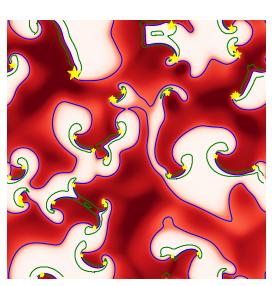

0

In [501]:
n_lst, x_lst, y_lst = get_tips(contours_raw, contours_inc)
tip_states = {'n': n_lst, 'x': x_lst, 'y': y_lst}
print(f"sigma = {sigma} and threshold = {threshold}.")
fig = plot_buffer(img_nxt, img_inc, contours_raw, contours_inc, tips, 
                  figsize=(5,5),max_marker_size=200, lw=1);
plt.grid('on')
plt.show()
beep(2)

In [26]:
# import pandas as pd

# @njit
# def unpad(X, pad, width, rejection_distance):
#     '''unpads 1 coordinate x or y for the padding: 
#     [0... pad | pad ... width + pad | width + pad ... width + 2 * pad]
#     return -9999 if X is within rejection_distance of the edge,
#     return X if X is in [pad ... width + pad], which is if X is in the unpadded frame, which has width = width
#     else return X reflected onto the unpadded frame'''
#     P  = rejection_distance
#     X -= pad
#     if X < -P:
#         X = -9999 # throw out X later
#     elif X < 0:
#         X += width
#     if X > width+P:
#         X = -9999 # throw out X later
#     elif X >= width:
#         X -= width
#     return X

In [47]:
#padded spiral tips are produced with at pixel percision of about 13 digits.
# note that this is not the same as accuracy, which will depend on sigma, threshold, and V_threshold

# test functions for unpad
assert(0==unpad(X=20, pad=20, width=500, rejection_distance=10))
assert(unpad(X=19, pad=20, width=500, rejection_distance=10)==499)
assert(280==unpad(X=300, pad=20, width=500, rejection_distance=10))
assert(499==unpad(X=519, pad=20, width=500, rejection_distance=10))
assert(10==unpad(X=530, pad=20, width=500, rejection_distance=10))
assert(-9999==unpad(X=531, pad=20, width=500, rejection_distance=10))
assert(490==unpad(X=10, pad=20, width=500, rejection_distance=10))
assert(-9999==unpad(X=9, pad=20, width=500, rejection_distance=10))

In [50]:
# @njit
# def unpad_xy_position (position, pad_x, width, rejection_distance_x, 
#                        pad_y, height, rejection_distance_y):
#     x = unpad(X=position[0], pad=pad_x, width=width, rejection_distance=rejection_distance_x)
#     y = unpad(X=position[1], pad=pad_y, width=height, rejection_distance=rejection_distance_y)
#     return x,y    

In [165]:
# def my_numba_list_to_python_list(numba_lst):
#     normal_list = []
#     for lst in numba_lst:
#         normal_list.append(list(lst))
#     return normal_list

In [365]:
unpad(X=499, pad=0, width=500, rejection_distance=0)

499

In [170]:
# tme = 0.038838388


In [177]:
# y_lst
#                     's': tuple(n_lst)})


# (unsuccessful) using a context manager to log tips (slows down sim significantly and doesn't make files that pandas imports easily.


In [255]:
# #make file for logging results
# output_dir = nb_dir+'/Data/Log'
# if not os.path.exists(output_dir):
#     os.mkdir(output_dir)
    
# output_fn = 'test-pbc-tips-1.csv'
# output_file = get_incremented_output_filename(output_dir, output_fn)
# with open(output_file, 'w') as opened_file:
#     opened_file.write('s1,s2,t,x,y\n')


# with open(output_file, 'a') as opened_file:
# #     s1_lst, s2_lst, x_lst, y_lst = map_pbc_tips_back(tips=tips, pad=pad, width=width, height=height, 
# #                   edge_tolerance=edge_tolerance, atol = 1e-11)
# #     stdout = str((str(tuple(s1_lst)),str(tuple(s2_lst)),float(np.around(tme, 2)),str(tuple(x_lst)),str(tuple(y_lst))))[1:-1]+'\n'
# #     stdout.replace("\'",'''\"''')
#     #     stdout = str((float(np.around(tme, 2)),tuple(s1_lst),tuple(s2_lst),tuple(x_lst),tuple(y_lst)))[1:-1]+'\n'
#     opened_file.write(stdout.replace("\'",'''\"'''))
    
# #     printProgressBar(step + 1, nsteps, prefix = 'Progress:', suffix = 'Complete', length = 50)
# beep(3)

In [257]:
# s_mapped_lst, x_mapped_lst, y_mapped_lst = tips_mapped



In [248]:
# float(np.around(tme, 2))
# str(tuple(s1_lst)),str(tuple(s2_lst)),str(tuple(x_lst)),str(tuple(y_lst))


'/Users/timothytyree/Documents/GitHub/care/notebooks/Data/Log/test-pbc-tips-9.csv'

In [88]:
test_fn = 'Data/tip_log_from_ic_600x600.101_at_time_308.5.csv'
# pd.read_csv(test_fn)

100000


In [87]:
# np.argwhere(xy_lst,xy)
# pd.read_csv(output_file)#, tupleize_cols=True)

In [ ]:
# {'x':tips_mapped[1], 'y': tips_mapped[2]}
# tips_mapped[1:]#'s':list(tips_mapped[0])
print(tips_mapped[2])
# df = pd.DataFrame(tips_mapped[1:])#, columns=['s','x','y'])

In [254]:
series = pd.Series(x_mapped_lst)
tol = 1.e-12 #greater than to 5.e-14
error_array = np.diff(np.sort(series[series.duplicated()]))
print(error_array[error_array<tol])

[0.00000000e+00 0.00000000e+00 5.68434189e-14 3.41060513e-13
 0.00000000e+00 0.00000000e+00 5.68434189e-14 5.68434189e-14
 1.13686838e-13 5.68434189e-14 5.68434189e-14 0.00000000e+00]


In [255]:
series = pd.Series(y_mapped_lst)
tol = 1.e-12 #greater than to 5.e-14
error_array = np.diff(np.sort(series[series.duplicated()]))
print(error_array[error_array<tol])

[0.00000000e+00 0.00000000e+00 5.68434189e-14 5.68434189e-14
 0.00000000e+00 0.00000000e+00]


In [195]:
#now remove duplicates
xy_zipped = [xy for xy in zip(x_mapped_lst, y_mapped_lst)]

In [214]:
# xy_df.drop_duplicates(subset=['x','y'])
len(s_mapped_lst)

60

In [217]:
len(x_mapped_lst)

60

In [227]:
s_tips[0]

(0, 0)

In [262]:
len(tips_mapped[0])

60

## helper functions for intersect

In [867]:
# def _rectangle_intersection_(x1, y1, x2, y2):
#     S1, S2, S3, S4 = _rect_inter_inner(x1, x2)
#     S5, S6, S7, S8 = _rect_inter_inner(y1, y2)

#     C1 = np.less_equal(S1, S2)
#     C2 = np.greater_equal(S3, S4)
#     C3 = np.less_equal(S5, S6)
#     C4 = np.greater_equal(S7, S8)

#     ii, jj = np.nonzero(C1 & C2 & C3 & C4)
#     return ii, jj
import inspect

In [870]:
print(inspect.getsource(intersection))

def _rect_inter_inner(x1, x2):
    n1 = x1.shape[0]-1
    n2 = x2.shape[0]-1
    
    minx1 = _min_within(x1,n1)
    maxx1 = _max_within(x1,n1)
    minx2 = _min_within(x2,n2)
    maxx2 = _max_within(x2,n2)
    
    S1 = np.zeros((n2,n1))
    S3 = S1.copy()
    for j in range(n2):
        S1[j] = minx1
        S3[j] = maxx1
    S2 = np.zeros((n1,n2))
    S4 = S2.copy()
    for j in range(n1):
        S2[j] = maxx2
        S4[j] = minx2
    return S1.T, S2, S3.T, S4



# DONE: optimize intersection.py

In [1077]:
# np.diff(np.column_stack((x1, y1)),axis=0)
from lib.intersection import *

In [643]:
# (sum(X1-X2)==0).all()

In [1041]:
# sum(sum(S1-S1b))==0

# sum(sum(S2-S2b))==0

# sum(sum(S3-S3b))==0

# sum(sum(S4-S4b))==0

array([], dtype=float64)

In [1078]:
_rectangle_intersection_(x1,y1,x2,y2)

(array([], dtype=int64), array([], dtype=int64))

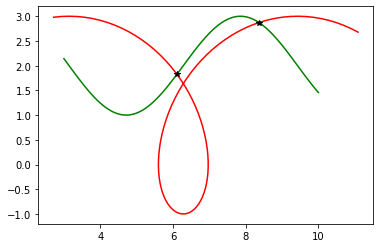

In [1080]:
a, b = 1, 2
phi = np.linspace(3, 10, 100)
x1 = a*phi - b*np.sin(phi)
y1 = a - b*np.cos(phi)

x2=phi
y2=np.sin(phi)+2
x,y=intersection(x1,y1,x2,y2)

plt.plot(x1,y1,c='r')
plt.plot(x2,y2,c='g')
plt.plot(x,y,'*k')
plt.show()

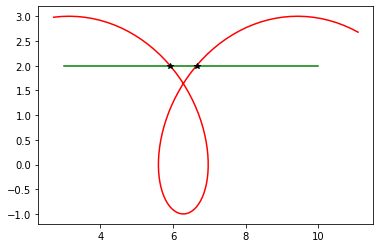

In [1081]:
#test that it works for vertical segments
a, b = 1, 2
phi = np.linspace(3, 10, 100)
x1 = a*phi - b*np.sin(phi)
y1 = a - b*np.cos(phi)

x2=phi
y2=0.*np.sin(phi)+2
x,y=intersection(x1,y1,x2,y2)

plt.plot(x1,y1,c='r')
plt.plot(x2,y2,c='g')
plt.plot(x,y,'*k')
plt.show()

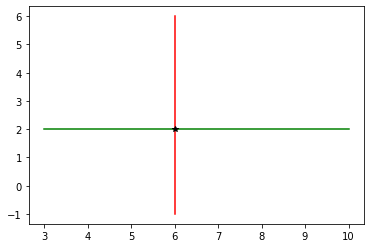

In [1082]:
#test that it works for vertical segments
a, b = 1, 2
phi = np.linspace(3, 10, 100)
x1 = 6.+ 0*phi#a*phi - b*np.sin(phi)
y1 = phi-4#a - b*np.cos(phi)

x2=phi
y2=0.*np.sin(phi)+2
x,y=intersection(x1,y1,x2,y2)

plt.plot(x1,y1,c='r')
plt.plot(x2,y2,c='g')
plt.plot(x,y,'*k')
plt.show()

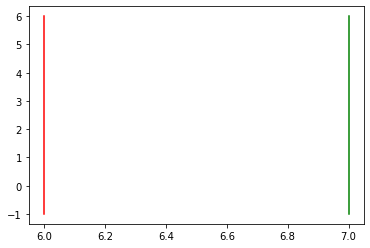

In [1083]:
#test that it works for vertical segments
a, b = 1, 2
phi = np.linspace(3, 10, 100)
x1 = 6.+ 0*phi#a*phi - b*np.sin(phi)
y1 = phi-4#a - b*np.cos(phi)

x2=x1+1.#phi
y2=y1#0.*np.sin(phi)+2
x,y=intersection(x1,y1,x2,y2)

plt.plot(x1,y1,c='r')
plt.plot(x2,y2,c='g')
plt.plot(x,y,'*k')
plt.show()

# optimize get_tips

it looks like the fastest improvement I'm getting is down to about 2 seconds for my use case.  This is because the relatively complicated intersection function needs to get called NxM times for N=num of contour a and M = num of contour b.  This can be improved by quickly checking if an intersection exists.  how might I do this?

#the lowest level function determines if there exists an intersection, and it takes the longest. :(
#pulling it out doesn't speed things up appreciably

I think I can get this (maybe?) O(n^2) intersection algorithm beat with what I was using in the horrible Javascript implementation, which is __O(n)__.

In [ ]:
# from lib.get_tips import *
# from numba import prange

# from lib.intersection import *
# from lib.get_tips import *

In [2]:
#Make a naive padded texture that enforces periodic boundary conditions
txt = np.load(f'Data/buffer_chaos_circle6_sigma_5_threshold_0.6_wrapping_true_at_time_5400.0.npy')
dtexture_dt = 0.*txt.copy()
get_time_step(txt,dtexture_dt)

edge_tolerance = 0
pad = 0
sigma = 1
threshold = 0.95

padded_txt, dpadded_txt_dt = textures_to_padded_textures(txt, dtexture_dt,pad=pad)

print(padded_txt.shape)
print(dpadded_txt_dt.shape)

#compute contours. type 1 = contours_raw, type 2 = contours_incimg_nxt = padded_txt.copy()
# img_inc = ifilter(dtexture_dt[...,0])  #mask of instantaneously increasing voltages 
# img_nxt = txt[...,0].copy()

img_nxt = padded_txt.copy()
img_inc = ifilter(dpadded_txt_dt)  #mask of instantaneously increasing voltages 

img_inc = filters.gaussian(img_inc,sigma=sigma)
contours_raw = measure.find_contours(img_nxt, level=0.5,fully_connected='low',positive_orientation='low')
contours_inc = measure.find_contours(img_inc, level=threshold)#,fully_connected='low',positive_orientation='low')


(512, 512)
(512, 512)


In [8]:
retval = get_tips(tuple(contours_raw),tuple(contours_inc));

In [19]:
# # #original code reference # @njit
# def get_tips(contours_raw, contours_inc):
#     '''returns tips with indices of parent contours'''
#     n_list = []; x_lst = []; y_lst = []
#     for n1, c1 in enumerate(contours_raw):
#         for n2, c2 in enumerate(contours_inc):
#             x1, y1 = (c1[:, 0], c1[:, 1])
#             x2, y2 = (c2[:, 0], c2[:, 1])
#             x, y = intersection(x1, y1, x2, y2)
#             if len(x)>0:
#                 s = (n1,n2)
#                 x = list(x)
#                 y = list(y)
#                 n_list.append(s)
#                 x_lst.append(x)
#                 y_lst.append(y)
#     return n_list, x_lst, y_lst

In [12]:
# # @njit(cache=True)
# def get_tips(contours_a,contours_b):
#     '''returns tips with indices of parent contours returned as the nested list, n_list.
#     contours_a,contours_b are each tuples of m-by-2 np.ndarrays.
#     each member is a 1D line.  
    
#     get_tips returns all intersections of 
#     contours_a with contours_b.  
#     will throw a TypingError exception if either input tuple is empty.
    
#     if you get a nonsingular matrix error, make sure that you`re not comparing a contour to itself.'''
#     n_list = List(); x_list = List(); y_list = List();
#     ncr = len(contours_a); nci = len(contours_b)
#     for n1 in prange(ncr):
#         for n2 in prange(nci):
# #     for n1, c1 in enumerate(contours_a):
# #         for n2, c2 in enumerate(contours_b):
#             c1 = contours_a[n1]
#             c2 = contours_b[n2]
#             x1 = c1[:, 0]
#             y1 = c1[:, 1]
#             x2 = c2[:, 0]
#             y2 = c2[:, 1]
#             x,y = intersection(x1, y1, x2, y2)
#             if len(x)>0:
#                 s = (n1,n2)
#                 xl = list(x)
#                 yl = list(y)
#                 n_list.append(s)
#                 x_list.append(xl)
#                 y_list.append(yl)
#     return n_list, x_list, y_list

In [1355]:
list(retval[1])

[[94.40598356654313],
 [4.757124477254592, 70.59466606577625],
 [63.46909489276186, 50.09620885066247],
 [15.45556769905707],
 [93.92799490929426],
 [148.6264747980347],
 [142.27515946218438, 158.27770971960348],
 [145.05953489102177, 139.0844938765144],
 [223.9352840239717, 266.9757498435436],
 [257.0868653172777, 228.23974488425034],
 [297.9859671764745, 262.56554019044415],
 [296.08708631528293, 310.0086162886364],
 [369.4868153147052, 326.20033903241574],
 [360.8296343352165, 340.38624515466046],
 [314.11883924529235, 293.78258592717316],
 [370.075292022259, 412.1725760338893],
 [487.1431335079494, 464.2220087946094],
 [468.8446973234902, 458.14358634237806],
 [505.41412966736465],
 [508.1188092991977]]

In [1382]:
import numba

In [1377]:
# #maybe a structured dict will be more parallelizable by the compiler
# #nope
# @njit(parallel=True)
# def get_tips(contours_a,contours_b):
#     '''returns tips with indices of parent contours returned as the nested list, n_list.
#     contours_a,contours_b are each tuples of m-by-2 np.ndarrays.
#     each member is a 1D line.  
    
#     get_tips returns all intersections of 
#     contours_a with contours_b.  
#     will throw a TypingError exception if either input tuple is empty.
    
#     if you get a nonsingular matrix error, make sure that you`re not comparing a contour to itself.'''
#     out = Dict()
# #     n_list = List(); x_list = List(); y_list = List();
#     ncr = len(contours_a); nci = len(contours_b)
#     for n1 in prange(ncr):
#         for n2 in prange(nci):
# #     for n1, c1 in enumerate(contours_a):
# #         for n2, c2 in enumerate(contours_b):
#             c1 = contours_a[n1]
#             c2 = contours_b[n2]
#             x1 = c1[:, 0]
#             y1 = c1[:, 1]
#             x2 = c2[:, 0]
#             y2 = c2[:, 1]
#             x,y = intersection(x1, y1, x2, y2)
#             if len(x)>0:
#                 s = (n1,n2)
#                 xl = list(x)
#                 yl = list(y)
#                 out[s]=(xl,yl)
#     return out
# #                 n_list.append(s)
# #                 x_list.append(xl)
# #                 y_list.append(yl)
# #     return n_list, x_list, y_list

In [996]:
x1, y1, x2, y2 = retval
test(x1,y1,x2,y2)
# print(intersection(x1, y1, x2, y2))
# print((x1, y1, x2, y2))
# type(x2)

(array([], dtype=float64), array([], dtype=float64))

In [1398]:
numba.typeof(tuple(contours_raw))
numba.typeof(tuple(contours_inc))

tuple(array(float64, 2d, C) x 24)

In [1364]:
# n_list, x_lst, y_lst = get_tips(tuple(contours_raw), tuple(contours_inc))
d.update?

In [1122]:
a = List()
a.append(1.2)

In [1125]:
print(a)

[1.2]


In [773]:
len(contours_raw)
for c in contours_raw:
    print(c.shape[0])

146
413
727
56
243
226
2248
1400
123
766
614
48
30


In [1222]:
#the lowest level function determines if there exists an intersection, and it takes the longest. :(
#pulling it out doesn't speed things up appreciably
# @njit
# def get_tips_2(contours_a,contours_b):
#     '''returns tips with indices of parent contours returned as the nested list, n_list.
#     contours_a,contours_b are each tuples of m-by-2 np.ndarrays.
#     each member is a 1D line.  
    
#     get_tips returns all intersections of 
#     contours_a with contours_b.  
#     will throw a TypingError exception if either input tuple is empty.
    
#     if you get a nonsingular matrix error, make sure that you`re not comparing a contour to itself.'''
#     n_list = List(); x_list = List(); y_list = List();
#     ncr = len(contours_a); nci = len(contours_b)
#     for n1, c1 in enumerate(contours_a):
#         for n2, c2 in enumerate(contours_b):
#             x1 = c1[:, 0]
#             y1 = c1[:, 1]
#             x2 = c2[:, 0]
#             y2 = c2[:, 1]
#             ii,jj = _rectangle_intersection_(x1, y1, x2, y2)
#             if len(ii)>0:
#                 x,y = _intersection_after_r_i_(x1, y1, x2, y2,ii,jj)
#                 s = (n1,n2)
#                 xl = list(x)
#                 yl = list(y)
#                 n_list.append(s)
#                 x_list.append(xl)
#                 y_list.append(yl)
#     return n_list, x_list, y_list

In [1274]:
@njit(parallel=True)
def _min_within(x,n):
    '''compare every two entries and return the min of the two.
    n = int(x.shape[0] - 1)'''
    out = np.zeros(n, dtype=np.float64)
    for j in prange(n):
        out[j] = min((x[j], x[j+1]))
    return out

In [1262]:
x = np.array([1,2,3,4])

In [1428]:
_min_within(x,3)

array([1., 2., 3.])

# (deprecated) get lewinger marching cubes to work for spiral tip detection for a single frame.

In [310]:
# !pip install bpy
#TODO: get bpy using conda?
# import bpy

In [311]:
# !pip install visvis

In [312]:
# import visvis as vv # doctest: +SKIP
# from skimage.measure import marching_cubes_lewiner
# verts, faces, normals, values = marching_cubes_lewiner(myvolume, 0.0) # doctest: +SKIP
# vv.mesh(np.fliplr(verts), faces, normals, values) # doctest: +SKIP
# vv.use().Run() # doctest: +SKIP

In [305]:
# import inspect

In [304]:
# print(inspect.getsource(marching_cubes_lewiner))

In [29]:
measure.find_contours?

In [1429]:
# _min_within.parallel_diagnostics(level=4)

## 3D/2D use of Lewinger marching cubes

In [2]:
file = search_for_file()

File: /Users/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-1/ic-out/ic_200x200.120.32.npz


In [29]:
file = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-1/ic-out/ic_200x200.120.32.npz'
txt = load_buffer(file)

In [30]:
myvolume = txt[...,:1]
myvolume = np.concatenate([myvolume,myvolume], axis=-1)

In [28]:
verts, faces, normals, values = marching_cubes_lewiner(myvolume, 0.5) # doctest: +SKIP

<ipython-input-28-b9651ed5a9ed>:1: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  verts, faces, normals, values = marching_cubes_lewiner(myvolume, 0.5) # doctest: +SKIP


In [31]:
from skimage import measure


- runtime with `allow_degenerate=True` is ~30ms.
- runtime with `allow_degenerate=False` is  ~30ms.
- the number of faces/verts was the same in either case for this example.

In [52]:
verts, faces, normals, values =  measure.marching_cubes(
    volume=myvolume,
    level=0.5,
    spacing=(1.0, 1.0, 1.0),
    gradient_direction='descent',
    step_size=1,
    allow_degenerate=False,
    method='lewiner',
    mask=None,
)

In [54]:
print(verts.shape)
print(faces.shape)
print(normals.shape)
print(values.shape)

(2512, 3)
(2500, 3)
(2512, 3)
(2512,)


### DONE: visualize the "surfaces" returned by scatter plotting all xy coords of vertices 
they make sense given the image

In [59]:
# #opens a 3D window to visualize the 3D "surface". Produces GIL lock until window is closed...
# import visvis as vv # doctest: +SKIP
# vv.mesh(np.fliplr(verts), faces, normals, values) # doctest: +SKIP
# vv.use().Run() # doctest: +SKIP

In [123]:
# plt.imshow(txt)

## TODO: compress the "surfaces" returned into 1D contours
- TODO(optional?): collect topologically distinct 1D contours
- TODO: make the output have the same form as the marching squares algorithm
- TODO(optional): show a toy case/example spiral tip detection where the old marching squares algorithm disagrees with lewinger marching cubes/squares
- TODO: incorporate lewinger marching squares into the spiral tip detection routine.  Does this resolve the funky birth-death rates?
- TODO(optional): consider tweaking the original C++ code to (i) return topologically segmented contours, (ii) explicitely obey periodic boundary conditions

## TODO: to compress 3D to 2D, it is sufficient to find the collection of all links/edges within the first/top plane.  
- boo = all vertices that are in the first/top plane
- bee = all edges of all vertices
- brie = all edges that are in the top plane

- then, collect all edges that are connected.  return as a linked list.
- (^there, explicitely enforce pbc)
- return the list of vertex locations
- then, TODO: visualize each contour, coloring by contour ID. :-)


In [128]:
for j in range(10000):
    zero_txt = txt.copy()*0.
    time_step(txt, h=0.025, zero_txt=zero_txt)

In [132]:
#compute contours for voltage
myvolume = txt[...,:1]
myvolume = np.concatenate([myvolume,myvolume], axis=-1)

verts, faces, normals, values =  measure.marching_cubes(
    volume=myvolume,
    level=0.5,
    spacing=(1.0, 1.0, 1.0),
    gradient_direction='descent',
    step_size=1,
    allow_degenerate=False,
    method='lewiner',
    mask=None,
)
boo = np.isclose(verts[...,-1],0.)
xycoords = verts[boo][...,:2]
height = txt.shape[1]

#DONE: compute dtxt_dt
zero_txt = txt.copy()*0.

#calculate discrete flow map
dtexture_dt = zero_txt.copy()
get_time_step(txt, dtexture_dt)

#DONE: compute the contours for change in voltage
myvolume = dtexture_dt[...,:1]
myvolume = np.concatenate([myvolume,myvolume], axis=-1)
verts_dt, faces_dt, normals_dt, values_dt =  measure.marching_cubes(
    volume=myvolume,
    level=0.0,
    spacing=(1.0, 1.0, 1.0),
    gradient_direction='descent',
    step_size=1,
    allow_degenerate=False,
    method='lewiner',
    mask=None,
)
boo_dt = np.isclose(verts_dt[...,-1],0.)
xycoords_dt = verts_dt[boo_dt][...,:2]#compute contours for voltage
myvolume = txt[...,:1]
myvolume = np.concatenate([myvolume,myvolume], axis=-1)

verts, faces, normals, values =  measure.marching_cubes(
    volume=myvolume,
    level=0.5,
    spacing=(1.0, 1.0, 1.0),
    gradient_direction='descent',
    step_size=1,
    allow_degenerate=False,
    method='lewiner',
    mask=None,
)
boo = np.isclose(verts[...,-1],0.)
xycoords = verts[boo][...,:2]
height = txt.shape[1]

#DONE: compute dtxt_dt
zero_txt = txt.copy()*0.

#calculate discrete flow map
dtexture_dt = zero_txt.copy()
get_time_step(txt, dtexture_dt)

#DONE: compute the contours for change in voltage
myvolume = dtexture_dt[...,:1]
myvolume = np.concatenate([myvolume,myvolume], axis=-1)
verts_dt, faces_dt, normals_dt, values_dt =  measure.marching_cubes(
    volume=myvolume,
    level=0.0,
    spacing=(1.0, 1.0, 1.0),
    gradient_direction='descent',
    step_size=1,
    allow_degenerate=False,
    method='lewiner',
    mask=None,
)
boo_dt = np.isclose(verts_dt[...,-1],0.)
xycoords_dt = verts_dt[boo_dt][...,:2]

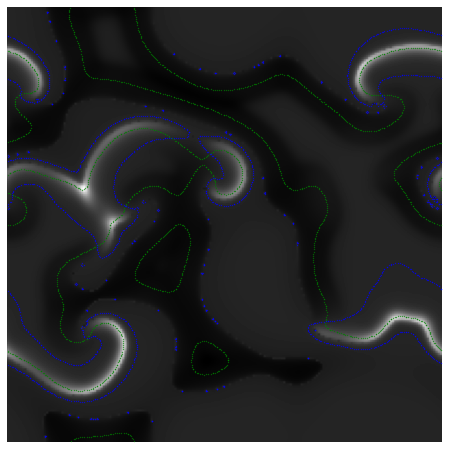

In [133]:
#are the xy coords actually yx? yes
#DONE: visualize contours.  do the intersections make plausible sense as spiral tips? Yes.
plt.figure(figsize=(8,8))
plt.imshow(dtexture_dt[...,0], cmap='gray')
# plt.imshow(txt[...,0], cmap='gray')
plt.scatter(x=xycoords[...,1],y=xycoords[...,0], s=.1, c='g')#looks more probable.
plt.scatter(x=xycoords_dt[...,1],y=xycoords_dt[...,0], s=.1, c='b')#looks more probable.

# plt.scatter(x=xycoords[...,1],y=height-xycoords[...,0], s=.1, c='r') #looks more probable.
# plt.scatter(x=xycoords_dt[...,1],y=height-xycoords_dt[...,0], s=.1, c='r') #looks more probable.

plt.axis('off')
plt.show()

In [135]:
#DONE: step forward in time until pbc are properly working
#TODO: select the set of all edges = 
faces[boo]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 3180 but corresponding boolean dimension is 3196

In [142]:
print( ( verts.shape, faces.shape, boo.shape ))

((3196, 3), (3180, 3), (3196,))


In [143]:
#TODO: segment vertices/edges to collect contours
#TODO: explicitely enforce pbc for ^this
#TODO: compute all intersections as before
#TODO: interpolate the  normals and values of either contour (keep it simple, stupid!)
#TODO(if that isn't reasonable): try the boundary of the increasing region again


In [144]:
faces

array([[   2,    1,    0],
       [   2,    3,    1],
       [   6,    5,    4],
       ...,
       [3190, 3167, 3192],
       [3188, 3194, 3189],
       [3195, 3194, 3188]])

In [161]:
edges = verts[faces]
#boe is the boolean index of edges in the first layer
boe = np.isclose(edges[...,-1],0.)
xycoords_edges = edges[boe][...,:2]

In [162]:
xycoords_edges

array([[  0.      ,  28.385918],
       [  1.      ,  28.049082],
       [  0.      ,  28.385918],
       ...,
       [198.      ,  57.17262 ],
       [199.      ,  57.602665],
       [198.      ,  57.17262 ]], dtype=float32)

In [165]:
faces[boe]

array([   1,    3,    1, ..., 3188, 3195, 3188])

- conclusion: lewiner marching cubes seems to work just fine, but it has the same problem of not enforcing periodic boundary conditions, and it doesn't keep track of which contours are which.

__easiest fix is to implement lewiner marching squares algorithm that explicitly enforces pbc__
- DONE: inspect the measure.find_contours function and see if I can scrape how they keep track of contours
    - DONE: explicitly enforce pbc
    - DONE use bilinear interpolation to resolve the ambiguity of this marching cubes algorithm.
        - DONE: is this sufficient to reproduce lewiner's marching cubes(squares) algorithm? Yes.

# testing laurener marching squares

In [232]:
# import inspect
# print(inspect.getsource(measure.find_contours))
# measure.find_contours._get_contour_segments
# _assemble_contours
# _assemble_contours
# from skimage.measure._find_contours_cy import _get_contour_segments
# segments = _get_contour_segments(array.astype(np.double), float(level),
#                                      fully_connected == 'high', mask=mask)
# type(_get_contour_segments)
# _get_contour_segments

In [308]:
#this is my fork of the skimage implementation
from lib.measure import find_contours as fc

In [235]:
retval = fc(array=txt[...,0], level=0.5)

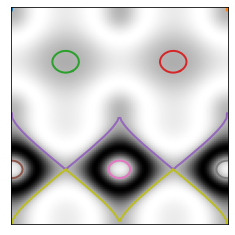

In [300]:
# Construct some test data
x, y = np.ogrid[-np.pi:np.pi:100j, -np.pi:np.pi:100j]
r = np.sin(np.exp((np.sin(x)**3 + np.cos(y)**2)))

# Find contours at a constant value of 0.8
# contours = fc(r, 0.8426762383307682)
contours = fc(r, 0.412)
# contours = fc(r, 0.415)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(r, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

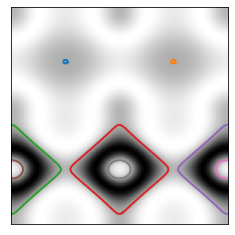

In [301]:
# Find contours at a constant value of 0.8
# contours = measure.find_contours(r, 0.8426762383307682)
contours = measure.find_contours(r, 0.3615845409156253, fully_connected='low', positive_orientation='low')
# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(r, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [214]:
r[49,24]

0.8426762383307682

In [220]:
r[24,75]

0.3615845409156253

In [225]:
measure.find_contours

<function skimage.measure._find_contours.find_contours(array, level, fully_connected='low', positive_orientation='low', *, mask=None)>

In [239]:
#^This case is complicated, use a simple 2x2 case instead!

In [243]:
fc(np.array([[1,0],[0,1]]), 0.5)

[array([[0. , 0.5],
        [0.5, 0. ]]),
 array([[1. , 0.5],
        [0.5, 1. ]])]

### testing behavior of skimage implementation.  it is indeed incorrect.

notes from tests
- positive_orientation='high' and positive_orientation='low' yield the same results
- case #9 appears to work as it should

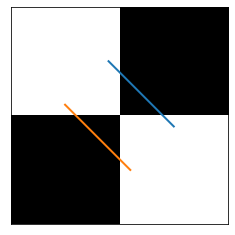

In [314]:
#model join.  skimage soln controls the ambiguity with fully_connected.
r = np.array([[1,0],[0,1]])
contours = measure.find_contours(r, 0.6, fully_connected='high')

fig, ax = plt.subplots()
ax.imshow(r, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

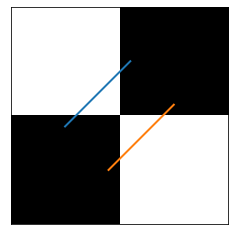

In [316]:
#model split. skimage soln controls the ambiguity with fully_connected.
r = np.array([[1,0],[0,1]])
contours = measure.find_contours(r, 0.4, fully_connected='low')

fig, ax = plt.subplots()
ax.imshow(r, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

### test cases for my find_contour as fc. These test certain topological guarantees.
- 10.20.2020 - all 6 primitive tests passed

In [1]:
#this is my fork of the skimage implementation
from lib.measure import find_contours as fc
import numpy as np
import matplotlib.pyplot as plt

100000


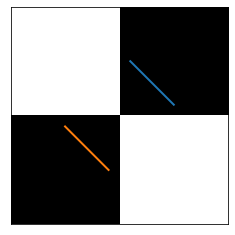

In [9]:
#case # 9 at 0.4, which should join
r = np.array([[1,0],[0,1]])
contours = fc(r, 0.4)
fig, ax = plt.subplots()
ax.imshow(r, cmap=plt.cm.gray)
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

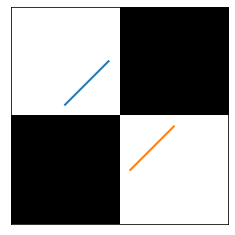

In [10]:
#case # 9 at 0.6, which should split
r = np.array([[1,0],[0,1]])
contours = fc(r, 0.6)


fig, ax = plt.subplots()
ax.imshow(r, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

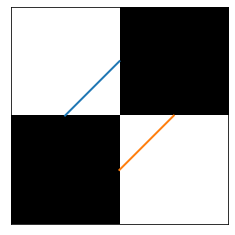

In [12]:
#case # 9 at 0.5, which should split
r = np.array([[1,0],[0,1]])
contours = fc(r, 0.5)
fig, ax = plt.subplots()
ax.imshow(r, cmap=plt.cm.gray)
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

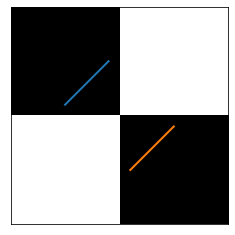

In [13]:
#case # 6 at 0.4, which should join
r = np.array([[0,1],[1,0]])
contours = fc(r, 0.4)
fig, ax = plt.subplots()
ax.imshow(r, cmap=plt.cm.gray)
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

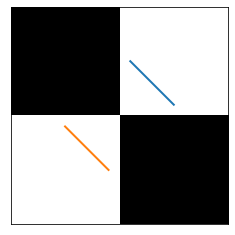

In [14]:
#case # 6 at 0.6, which should split
r = np.array([[0,1],[1,0]])
contours = fc(r, 0.6)


fig, ax = plt.subplots()
ax.imshow(r, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

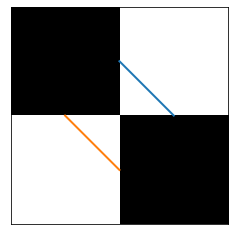

In [15]:
#case # 6 at 0.5, which should split
r = np.array([[0,1],[1,0]])
contours = fc(r, 0.5)


fig, ax = plt.subplots()
ax.imshow(r, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

# basic case for the lewiner marching cubes contour finder with periodic boundary conditions
the pbc solution.  realize that this should be done within cython.<br>
DONE: setting #cython: wraparound=True did not enforce pbc

In [1]:
#this is my fork of the skimage implementation
from lib.measure import find_contours as fc
import numpy as np
import matplotlib.pyplot as plt

100000


In [233]:
# mode = 'hard_boundary' #uses laurener aperiodic from skimage
mode = 'pbc' #uses my version with lewiner and periodic boundary conditions

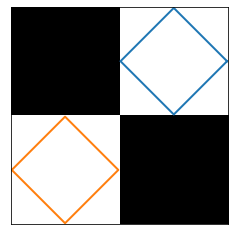

In [235]:
#untiled case
r = np.array([[0,1],[1,0]])
contours = fc(r, 0.51, mode=mode)


fig, ax = plt.subplots()
ax.imshow(r, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

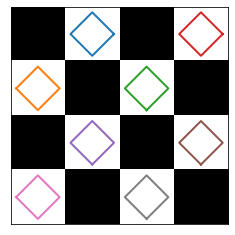

In [236]:
#tiled case
r = np.array([[0,1,0,1],[1,0,1,0],[0,1,0,1],[1,0,1,0]])
contours = fc(r, 0.6, mode=mode)


fig, ax = plt.subplots()
ax.imshow(r, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

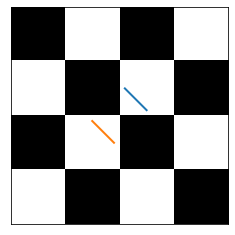

In [243]:
#tiled case with a mask that turns off the periodic boundary conditions
mask = 1+0*r
mask[:,0] = 0
mask[:,-1] = 0
mask[0,:] = 0
mask[-1,:] = 0
mask = mask.astype(np.bool8)

r = np.array([[0,1,0,1],[1,0,1,0],[0,1,0,1],[1,0,1,0]])
contours = fc(r, 0.6, mask = mask, mode=mode)


fig, ax = plt.subplots()
ax.imshow(r, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])

plt.show()

# testing the lewiner marching cubes contour finder with periodic boundary conditions
the easiest/fastest/cleanest way to explicitly enforce pbc is to just make a new cython function for it
- DONE: copy my lewiner marching squares method and test that it still works
- DONE: choose between either method in lib.measure.find_contours.py using a keyword argument
- DONE: edit _find_contours_pbc_cy.pyx to explicitely enforce pbc

In [2]:
# #this is my fork of the skimage implementation
# from lib.measure import find_contours as fc
# import numpy as np
# import matplotlib.pyplot as plt
# import os
# if not 'nb_dir' in globals():
#     nb_dir = os.getcwd()

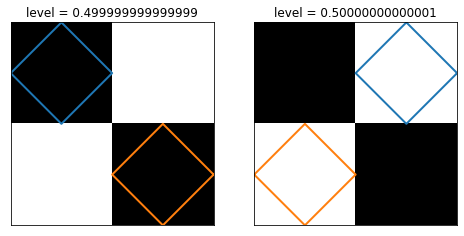

In [245]:
#untiled case with level less than half to double precision
save = True
r = np.array([[0,1],[1,0]])
fig, axs = plt.subplots(ncols = 2, figsize=(8,4))
ax = axs[0]
level = 0.499999999999999
contours = fc(r, level, mode='pbc')
ax.imshow(r, cmap=plt.cm.gray)
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
ax.set_title(f'level = {level}')
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])

#untiled case with level greater than half to double precision
ax = axs[1]
level = 0.50000000000001
contours = fc(r, level, mode='pbc')
ax.imshow(r, cmap=plt.cm.gray)
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
ax.set_title(f'level = {level}')
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])

if not save:
    plt.show()
else:
    os.chdir(nb_dir)
    os.chdir('Figures/methods')
    plt.savefig('example_marching_squares_lewiner_pbc_1.png')

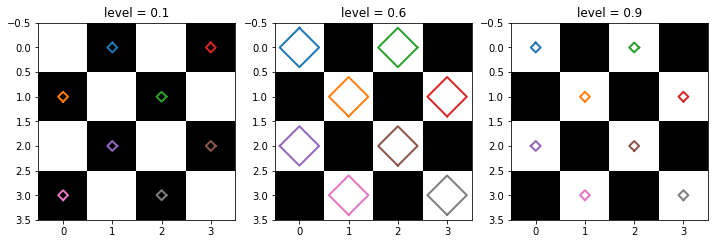

In [269]:
#tiled case
r = np.array([[1,0,1,0],[0,1,0,1],[1,0,1,0],[0,1,0,1]])
# r = np.array([[0,1,0,1],[1,0,1,0],[0,1,0,1],[1,0,1,0]])
# Display the image and plot all pbc contours found properly!
save = True
fig, axs = plt.subplots(ncols = 3, figsize=(12,4))
ax = axs[0]
level = 0.1
contours = fc(r, level)
ax.imshow(r, cmap=plt.cm.gray)
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
ax.set_title(f'level = {level}')
ax.axis('image')
# ax.set_xticks([])
# ax.set_yticks([])

ax = axs[1]
level = 0.6
contours = fc(r, level)
ax.imshow(r, cmap=plt.cm.gray)
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
ax.set_title(f'level = {level}')
ax.axis('image')
# ax.set_xticks([])
# ax.set_yticks([])

ax = axs[2]
level = 0.9
contours = fc(r, level)
ax.imshow(r, cmap=plt.cm.gray)
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
ax.set_title(f'level = {level}')
ax.axis('image')
# ax.set_xticks([])
# ax.set_yticks([])

if not save:
    plt.show()
else:
    os.chdir(nb_dir)
    os.chdir('Figures/methods')
    plt.savefig('example_marching_squares_lewiner_pbc_2.png')

### visualize ^this contour detector for the following nontrivial case

In [271]:
# Construct some test data
x, y = np.ogrid[-np.pi:np.pi:100j, -np.pi:np.pi:100j]
r = np.sin(np.exp((np.sin(x)**3 + np.cos(y)**2)))
contours = fc(r,.5)#, 0.3615845409156253)#, fully_connected='low', positive_orientation='low')

In [272]:
print('the max distances between consecutive contour points is:')
for contour in contours:
    mxnd = np.max(np.linalg.norm(np.diff(contour, axis=0), axis=-1))
    print(mxnd)
print('let`s set the threshold to a default distance of 2 pixels.')

the max distances between consecutive contour points is:
99.0
1.3877374168453274
1.3877374168453522
99.0
99.0
1.2392947369141163
let`s set the threshold to a default distance of 2 pixels.


In [273]:
#boolean functions for continuity.  helps with periodic functions
def _get_contiguous_mask(contour, threshold=2):
    '''returns boolean array based on proximity according to Euclidean distance.
    an entry is False if the contour jumps accross a boundary.'''
    return np.linalg.norm(np.diff(contour, axis=0), axis=-1)<threshold
def _is_contour_contiguous(contour, threshold=2):
    '''returns True is the contour makes no jumps accross the boundary.'''
    mask = _get_contiguous_mask(contour, threshold=threshold)
    return mask.all()
def _are_ends_contiguous(contour):
    '''returns whether the first and final contour points are contiguous.'''
    return (contour[0] == contour[-1]).all()

In [274]:
#informal print tests for the above boolean functions
print('# discontinuities, is contiguous?, are ends equal?')
for n, contour in enumerate(contours):
    print(f"for contour #{n}:")
    mask = ~_get_contiguous_mask(contour, threshold=2)
    print('\t',sum(mask), _is_contour_contiguous(contour, threshold=2),_are_ends_contiguous(contour))

# discontinuities, is contiguous?, are ends equal?
for contour #0:
	 5 False True
for contour #1:
	 0 True True
for contour #2:
	 0 True True
for contour #3:
	 1 False True
for contour #4:
	 2 False True
for contour #5:
	 0 True True


In [275]:
# contour = contours[3]
# mask = _get_contiguous_mask(contour, threshold=2)
# # mask = np.concatenate([np.array([True]),mask])
# indices = np.nonzero(~mask)[0]+1
# contour_lst = np.split(contour,indices)
# # mask_lst = np.split(mask,indices)

In [276]:
def _split_contour_into_contiguous(contour, threshold=2):
    '''returns a list of contiguous contours. 
    threshold = the max number of pixels two points may be separated by to be considered contiguous.
    split the contour into a contour_lst of contiguous contours.
    the last contour may have length 1 or 0.  simply ignore those later.'''
    mask = _get_contiguous_mask(contour, threshold=threshold)
    indices = np.nonzero(~mask)[0]+1
    contour_lst = np.split(contour,indices)
    return contour_lst

In [279]:
#test that split_contour_into_contiguous returns only contours that are contiguous
x, y = np.ogrid[-np.pi:np.pi:100j, -np.pi:np.pi:100j]
r = np.sin(np.exp((np.sin(x)**3 + np.cos(y)**2)))
contours = fc(r, level=.5, mode='pbc')

for contour in contours:
    contour_lst = _split_contour_into_contiguous(contour)
    for ct in contour_lst:
        assert(_is_contour_contiguous(ct))

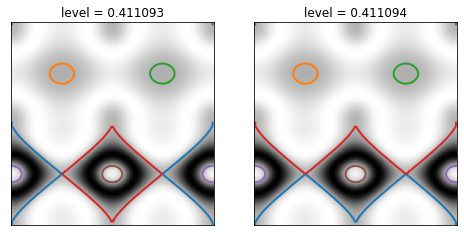

In [301]:
# Display the image and plot all pbc contours found properly!
save = True
fig, axs = plt.subplots(ncols = 2, figsize=(8,4))
ax = axs[0]
#plot lower level bound of the separatrix
level = 0.411093
contours = fc(r, level, mode='pbc')
ax.imshow(r, cmap=plt.cm.gray)
for contour in contours:
    contour_lst = _split_contour_into_contiguous(contour)
    #plot the first segment of this pbc contour
    ct = contour_lst[0]
    p = ax.plot(ct[:, 1], ct[:, 0], linewidth=2)
    #if there are more segments, plot them as well.
    if len(contour_lst)>1:
        color = p[0].get_color()
        for ct in contour_lst[1:]:
            ax.plot(ct[:, 1], ct[:, 0], linewidth=2, color=color)
ax.set_title(f'level = {level}')
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])

ax = axs[1]
#plot lower level bound of the separatrix
level = 0.411094
contours = fc(r, level, mode='pbc')
ax.imshow(r, cmap=plt.cm.gray)
for contour in contours:
    contour_lst = _split_contour_into_contiguous(contour)
    #plot the first segment of this pbc contour
    ct = contour_lst[0]
    p = ax.plot(ct[:, 1], ct[:, 0], linewidth=2)
    #if there are more segments, plot them as well.
    if len(contour_lst)>1:
        color = p[0].get_color()
        for ct in contour_lst[1:]:
            ax.plot(ct[:, 1], ct[:, 0], linewidth=2, color=color)
ax.set_title(f'level = {level}')
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])

if not save:
    plt.show()
else:
    os.chdir(nb_dir)
    os.chdir('Figures/methods')
    plt.savefig('example_marching_squares_lewiner_pbc_3.png')

# (homerun) compute spiral tip locations points using this wonderful method

In [3]:
# from lib.measure import find_contours
# from lib.measure._utils_find_contours import *

In [27]:
#import an example inital condition txt and step forward until pbc are enforced (up to t = 500 ms).
file = nb_dir+'/Data'+'/initial-conditions-suite-1/ic-out/ic_200x200.120.32.npz'
txt = load_buffer(file)
for j in range(20000):
    zero_txt = txt.copy()*0.
    time_step(txt, h=0.025, zero_txt=zero_txt)
os.chdir(nb_dir+'/Data')
np.savez_compressed('test_txt.npz',txt)

KeyboardInterrupt: 

In [328]:
#compute as discrete flow map dtexture_dt
zero_txt = txt.copy()*0.

#calculate 
dtexture_dt = zero_txt.copy()
get_time_step(txt, dtexture_dt)

#compute the images to find isosurfaces of
img    = txt[...,0]
dimgdt = dtexture_dt[...,0]

#compute both families of contours
contours1 = find_contours(img, level = 0.5)
contours2 = find_contours(dimgdt, level = 0.0)

#find_tips
n_list, x_lst, y_lst = find_tips(contours1, contours2)

num_tips = count_tips(x_lst)
x_values = np.array(_flatten(x_lst))
y_values = np.array(_flatten(y_lst))

In [166]:
# def find_tips(contours1, contours2):
#     '''returns tips with indices of parent contours.
#     _split_contour_into_contiguous is used to delete segments that jump accross the edges of the computational domain.'''
#     n_list = []; x_lst = []; y_lst = []
#     for n1, contour1 in enumerate(contours1):
#         contour1_lst = split_contour_into_contiguous(contour1)
#         for c1 in contour1_lst:
#             for n2, contour2 in enumerate(contours2):
#                 contour2_lst = split_contour_into_contiguous(contour2)
#                 for c2 in contour2_lst:
#                     x1, y1 = (c1[:, 0], c1[:, 1])
#                     x2, y2 = (c2[:, 0], c2[:, 1])
#                     y, x = intersection(x1, y1, x2, y2)
#                     if len(x)>0:
#                         s = (n1,n2)
#                         x = list(x)
#                         y = list(y)
#                         n_list.append(s)
#                         x_lst.append(x)
#                         y_lst.append(y)
#     return n_list, x_lst, y_lst

In [7]:
#TODO: compute the intersection points of those contours
#Hint: use previously optimized intersect function to compute the locations of the spiral tips!
#TODO(later?): consider optimizing this slowest function get_tips using a cython implementation

In [309]:
# def _flatten(x_lst):
#     xlist = []
#     for xl in x_lst:
#         xlist.extend(xl)
#     return xlist



In [348]:
# def plot_contours_pbc(contours, ax, linewidth=2, min_num_vertices=1, alpha=1., linestyle = '-'):
#     for contour in contours:
#         if len(contour)>=min_num_vertices:
#             contour_lst = _split_contour_into_contiguous(contour)
#             #plot the first segment of this pbc contour
#             ct = contour_lst[0]
#             if len(ct)>min_num_vertices:
#                 p = ax.plot(ct[:, 1], ct[:, 0], linewidth=linewidth, alpha=alpha, linestyle=linestyle)
#                 #if there are more segments, plot them as well.
#                 if len(contour_lst)>1:
#                     color = p[0].get_color()
#                     for ct in contour_lst[1:]:
#                         if len(ct)>min_num_vertices:
#                             ax.plot(ct[:, 1], ct[:, 0], linewidth=linewidth, color=color, alpha=alpha, linestyle=linestyle)
# # def segment_and_filter_short_contours(contours, min_num_vertices=2):
# #     '''avoid using this function directly, as it destroys contour index information'''
# #     contours_lst_out = []
# #     for contour in contours:
# #         contour_lst = _split_contour_into_contiguous(contour)
# #         contour_lst_out = []
# #         #plot the first segment of this pbc contour
# #         ct = contour_lst[0]
# #         if len(ct)>=min_num_vertices:
# #             contour_lst_out.append(ct)
# #         #if there are more segments, plot them as well.
# #         if len(contour_lst)>1:
# #             for ct in contour_lst[1:]:
# #                 if len(ct)>=min_num_vertices:
# #                     contour_lst_out.append(ct)
# #         contours_lst_out.append(contour_lst_out)
# #     return contours_lst_out

NameError: name '_split_contour_into_contiguous' is not defined

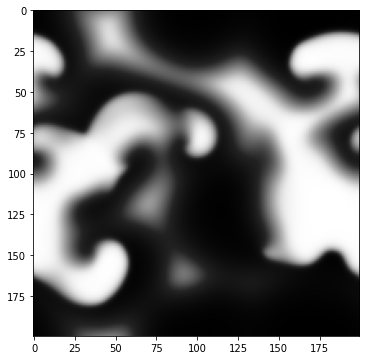

In [347]:
# Display the image and plot all pbc contours found properly!
save = False
fig, ax = plt.subplots(figsize=(6,6))
# fig, axs = plt.subplots(ncols = 2, figsize=(8,4))
# ax = axs[0]

# contours1 = fc(img, level=0.5, mode='pbc')
ax.imshow(img, cmap=plt.cm.gray)
plot_contours_pbc(contours1, ax, linewidth=2, min_num_vertices=5, linestyle='-')

# contours2 = fc(dimgdt, level=0.0, mode='pbc')
# ax.imshow(img, cmap=plt.cm.gray)
plot_contours_pbc(contours2, ax, linewidth=2, min_num_vertices=5, linestyle='--')

ax.scatter(x=x_values, y=y_values, s=90, c='yellow', marker='*', zorder=3)


ax.set_title(f"Number of Tips = {num_tips}")
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])

if not save:
    plt.show()
else:
    os.chdir(nb_dir)
    os.chdir('Figures/methods')
    plt.savefig('example_parameterless_tip_detection.png')

# dev intersection with seamless tip motion over periodic boundaries

- DONE(oops. ignore...): pad the input txt by 1 row and 1 column with wrapped boundary conditions (see prev pad, this may be really fast/done already)

- I can't do that because I made the find_contour obey pbc explicitly...

- DONE: whenever there's a jump, augment the contour at the jump with one more contour point

In [64]:
# #this is unused
# def pad_mat_by_1x1(mat):
#     '''pad the input txt by 1 row and 1 column with wrapped boundary conditions (see prev pad, this may be really fast/done already)'''
#     return np.pad(array = mat, pad_width = 1, mode = 'wrap')[1:,1:]

In [63]:
# mat = txt[...,0]
# retmat = pad_mat_by_1x1(mat)

# #test that the new first column matches the first old column
# assert ( np.isclose(retmat[0,:-1],mat[0,:]).all() ) 
# #test that the new last column matches the first old column
# assert ( np.isclose(retmat[-1,:-1],mat[0,:]).all() ) 

# #test that the new first row matches the first old row
# assert ( np.isclose(retmat.T[0,:-1],mat.T[0,:]).all() ) 
# #test that the new last row matches the first old row
# assert ( np.isclose(retmat.T[-1,:-1],mat.T[0,:]).all() ) 

In [254]:
# import numpy as np

# #boolean functions for continuity.  helps with periodic functions
# def _get_contiguous_mask(contour, threshold=2):
#     '''returns boolean array based on proximity according to Euclidean distance.
#     an entry is False if the contour jumps accross a boundary.'''
#     return np.linalg.norm(np.diff(contour, axis=0), axis=-1)<threshold
# def _is_contour_contiguous(contour, threshold=2):
#     '''returns True is the contour makes no jumps accross the boundary.'''
#     mask = _get_contiguous_mask(contour, threshold=threshold)
#     return mask.all()
# def _are_ends_contiguous(contour):
#     '''returns whether the first and final contour points are contiguous.
#     This appeared to always yield true in a few sample test cases.'''
#     return (contour[0] == contour[-1]).all()

# def _split_contour_into_contiguous(contour, threshold=2):
#     '''returns a list of contiguous contours. 
#     threshold = the max number of pixels two points may be separated by to be considered contiguous.
#     split the contour into a contour_lst of contiguous contours.
#     the last contour may have length 1 or 0.  simply ignore those later.'''
#     mask = _get_contiguous_mask(contour, threshold=threshold)
#     indices = np.nonzero(~mask)[0]+1
#     contour_lst = np.split(contour,indices)
#     return contour_lst

# def split_contour_into_contiguous(contour, threshold=2):
#     return _split_contour_into_contiguous(contour, threshold=threshold)

In [400]:
# def _bring_vertices_together(vmove, vtarget, width, height):
#     '''bring 2D vertex vmove as close as possible to 2D vertex 
#     vtarget by changing xy coordinates by width or height.'''
#     vw = np.array([width,0.])
#     vh = np.array([0.,height])
#     dist = np.linalg.norm(vmove-vtarget)
#     vtest = vmove + vw
#     dist_test = np.linalg.norm(vtest-vtarget)
#     if dist_test < dist:
#         vmove = vtest.copy()
#         dist = np.linalg.norm(vmove-vtarget)
#     else:
#         vtest = vmove - vw
#         dist_test = np.linalg.norm(vtest-vtarget)
#         if dist_test < dist:
#             vmove = vtest.copy()
#             dist = np.linalg.norm(vmove-vtarget)
#     vtest = vmove + vh
#     dist_test = np.linalg.norm(vtest-vtarget)
#     if dist_test < dist:
#         vmove = vtest.copy()
#         dist = np.linalg.norm(vmove-vtarget)
#     else:
#         vtest = vmove - vh
#         dist_test = np.linalg.norm(vtest-vtarget)
#         if dist_test < dist:
#             vmove = vtest.copy()
#             #dist = np.linalg.norm(vmove-vtarget)
#     return vmove

In [401]:
# def split_and_augment_contour_into_contiguous_segments(contour, width, height, threshold=2):
#     '''returns a list of contiguous contours with one contour vertex added from across the computational domain, mapped onto the local coordinates. 
#     threshold = the max number of pixels two points may be separated by to be considered contiguous.
#     split the contour into a contour_lst of contiguous contours.
#     the last contour may have length 1 or 0.  simply ignore those later.'''
#     mask = _get_contiguous_mask(contour, threshold=threshold)
#     if mask.all():
#         #the contour is contiguous, no augmentation necessary.  Return the input contour as a list of one contour segment
#         return [contour]
#     else:
#         #the contour is not contiguous, jumps occured accross boundary
#         indices = np.nonzero(~mask)[0]+1
#         contour_lst = np.split(contour,indices)
        
#         #augment the end of each contiguous segment with the start of the following segment, if there is a following segment
#         for n in range(len(contour_lst)-1):
#             ct      = contour_lst[n]
#             vtarget = ct[-1]
#             vmove   = contour_lst[n+1][0]
#             #map the next vertex onto the current vertex
#             vmapped = _bring_vertices_together(vmove, vtarget, width, height)
            
#             #print( f"Check {vmove} correctly moved to {vmapped} to meet {vtarget}.")
#             #if vmapped is not exactly on top of vtarget
#             if ~(vmapped==vtarget).all():
#                 #augment that contour with the mapped vertex
#                 contour_lst[n] = np.vstack([ct,vmapped])
#         return contour_lst

In [257]:
# #TODO: cython this shiz
# def find_tips(contours1, contours2):
#     '''returns tips with indices of parent contours.
#     contours1 and contours2 are a lists of numpy arrays.  
#     each such numpy array is an Nx2 array representing a contiguous contour (i.e. continuous in local xy coordinates).'''
#     n_list = []; x_lst = []; y_lst = []
#     for n1, contour1_lst in enumerate(contours1):
#         #contour1_lst = split_contour_into_contiguous(contour1)
#         for c1 in contour1_lst:
#             for n2, contour2_lst in enumerate(contours2):
#                 #contour2_lst = split_contour_into_contiguous(contour2)
#                 for c2 in contour2_lst:
#                     x1, y1 = (c1[:, 0], c1[:, 1])
#                     x2, y2 = (c2[:, 0], c2[:, 1])
#                     try:
#                         y, x = intersection(x1, y1, x2, y2)
#                     except Exception as e:
#                         print(e)
#                         print(f"x1 = {x1}")
#                         print(f"y1 = {y1}")
#                         print(f"x2 = {x2}")
#                         print(f"y2 = {y2}")
#                     #y, x = intersection(x1, y1, x2, y2)
#                     if len(x)>0:
#                         s = (n1,n2)
#                         x = list(x)
#                         y = list(y)
#                         n_list.append(s)
#                         x_lst.append(x)
#                         y_lst.append(y)
#     return n_list, x_lst, y_lst

In [258]:
# def contours_to_simple_tips_pbc(contours1,contours2,width, height,jump_threshold = 2,size_threshold = 6):
#     '''Find the intersection points of two families of contour lines.
#     contours_to_simple_tips_pbc returns spiral tips as a tuple of lists, n_lst, x_lst, y_lst.
#     n_lst = list of tuples with the first tuple value is the index of the parent contour1 and the second tuple value is the index of the parent contour2.
#     x_lst = list of lists of intersection x coordinates cooresponding to the tuples in n_lst.
#     y_lst = list of lists of intersection y coordinates cooresponding to the tuples in n_lst.
#     width, height = the number of rows?,columns? of the input image
#     jump_threshold = max distance in pixels to not be considered a jump
#     size_threshold = minimum number of vertices in a whole input contour to be considered 
    
#     pixels are taken to be centered at integer xy coordinates.
#     (nota bene for my original use case: a lot of 5 vertex contours were observed in contours2,
#     where contours1 and contour2 are results of lewiner marching squares (that used explicit pbc).  )    
#     '''
#     #segment and augment contours of the first family
#     contour1_lst_lst = []
#     for contour in contours1:
#         if len(contour) >= size_threshold:
#             contour1_lst = split_and_augment_contour_into_contiguous_segments(contour, width, height, threshold=jump_threshold)
#             contour1_lst_lst.append(contour1_lst)
#     #segment and augment contours of the second family
#     contour2_lst_lst = []
#     for contour in contours2:
#         if len(contour) >= size_threshold:
#             contour2_lst = split_and_augment_contour_into_contiguous_segments(contour, width, height, threshold=jump_threshold)
#             contour2_lst_lst.append(contour2_lst)

#     #detect tips as above. Print tip number as above
#     n_lst, x_lst, y_lst = find_tips(contour1_lst_lst, contour2_lst_lst)
#     return n_lst, x_lst, y_lst

In [259]:
#detect tips as above. count tip number as above

n_lst, x_lst, y_lst = contours_to_simple_tips_pbc(contours1,contours2,width, height,jump_threshold = 2,size_threshold = 6)
n_tips = count_tips(x_lst)
print(n_tips)

# n_list, x_lst, y_lst = find_tips(contour1_lst_lst, contour2_lst_lst)
# n_tips = count_tips(x_lst)

10


In [251]:
# jump_threshold = 2 #max distance in pixels to not be considered a jump
# size_threshold = 6 #minimum number of vertices in a whole pbc contour to be considered (a lot of 5 vertex contours were observed in contours2)
width, height = img.shape[:2]

#parse tips
# num_tips = count_tips(x_lst)
# x_values = np.array(flatten(x_lst))
# y_values = np.array(flatten(y_lst))

# rudimentary test shows stability in spiral tip number over long times with high time resolution 
- uses topologically dense method of detection (Caution! Very slow!)

In [39]:
#DONE: just time_step and compute num_tips after every time step
#DONE: move all helper files to a .py file
#DONE: restart kernel and run a few time steps to make sure everything imports correctly.
#DONE: optimize find_tips with cython or numba, whichever is easier
from lib import *
# from lib.measure import reduce_tips

In [40]:
# file = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-1/ic-out/ic_200x200.120.32.npz'
# txt = load_buffer(file)
# t   = 0. #ms

#load ^that loaded initial after 20000 steps = 500 ms at time_steps of size 0.025
file = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/test_txt.npz'
txt  = load_buffer(file)
t   = 500 #ms

t_list = []
n_list = []   

In [41]:
zero_txt = txt.copy()*0.
width, height = txt.shape[:2]

h    = 0.025 #ms
tmax = 3500#3025.600-2*h# 886.6-h#6000#600#510#600#505.225# #ms

V_threshold = 0.8
jump_threshold = 2 
size_threshold = 0
pad=2
decimals=10

In [42]:
num_steps = int(np.around((tmax-t)/h))
step_count = 0
while t<tmax:
    #TODO: insert functionality for saving every n frames
    
    #compute as discrete flow map dtexture_dt
    dtexture_dt = zero_txt.copy()
    get_time_step(txt, dtexture_dt)

    #compute the images to find isosurfaces of
    img    = txt[...,0]
    dimgdt = dtexture_dt[...,0]

    #compute both families of contours
    #appears to work     contours1 = find_contours(img,    level = 0.5)
    contours1 = find_contours(img,    level = V_threshold)
    contours2 = find_contours(dimgdt, level = 0.0)

    #find_tips
#     n_lst, x_lst, y_lst = contours_to_simple_tips_pbc(contours1,contours2,width, height, jump_threshold = 2, size_threshold = 6)
#     s1_values, s2_values, x_values, y_values = unwrap_and_reduce_tips(n_lst, x_lst, y_lst, width, height, pad=3)
#     

#     n_lst, x_lst, y_lst = contours_to_simple_tips_pbc(contours1,contours2,width, height, jump_threshold = 2, size_threshold = 0)
#     s1_values, s2_values, x_values, y_values = unwrap_and_reduce_tips(n_lst, x_lst, y_lst, width, height, pad=2, decimals=10)
#     n_tips = count_tips(x_values)

    #find_tips and measure tip topological/EP state
    s1_list, s2_list, x_lst, y_lst, v_lst, f_lst, s_lst = measure_system(contours1, contours2, width, height, txt, 
                                                                         jump_threshold = jump_threshold, 
                                                                         size_threshold = size_threshold, 
                                                                         pad=pad, decimals=decimals)
    n_tips = x_lst.size
    dict_out = {
        't': float(t),
        'n': int(n_tips),
        'x': tuple(x_lst),
        'y': tuple(y_lst),
        'n1': tuple(s1_list),
        'n2': tuple(s2_list),
        'v':v_lst,
        'f':f_lst,
        's':s_lst,
    }    
    
    #record data for current time
    t_list.append(t)
    n_list.append(n_tips)

    #forward Euler integration in time
    txt += h*dtexture_dt
    t   += h
    step_count += 1
    
    #progress bar that updates after each measurement
    printProgressBar(step_count, num_steps, prefix = 'Progress:', suffix = 'Complete', length = 50)
beep(3)

KeyboardInterrupt: 

In [43]:
# 32/num_steps*60 #seconds of run time per time step with recording
# 0.5334815226451792

In [44]:
#compute as discrete flow map dtexture_dt
dtexture_dt = zero_txt.copy()
get_time_step(txt, dtexture_dt)

#forward Euler integration in time
txt += h*dtexture_dt
t   += h

#compute as discrete flow map dtexture_dt
dtexture_dt = zero_txt.copy()
get_time_step(txt, dtexture_dt)
print(t)

1582.1000000015538


In [45]:
# V_threshold = 0.6
jump_threshold = 2 
size_threshold = 0
pad=2
decimals=9

#compute as discrete flow map dtexture_dt
dtexture_dt = zero_txt.copy()
get_time_step(txt, dtexture_dt)

#compute the images to find isosurfaces of
img    = txt[...,0]
dimgdt = dtexture_dt[...,0]

#compute both families of contours
#appears to work     contours1 = find_contours(img,    level = 0.5)
contours1 = find_contours(img,    level = V_threshold)
contours2 = find_contours(dimgdt, level = 0.0)

#find_tips and measure tip topological/EP state
s1_list, s2_list, x_lst, y_lst, v_lst, f_lst, s_lst = measure_system(contours1, contours2, width, height, txt, 
                                                                 jump_threshold = jump_threshold, 
                                                                 size_threshold = size_threshold, 
                                                                 pad=pad, decimals=decimals)
n_tips = x_lst.size
dict_out = {
't': float(t),
'n': int(n_tips),
'x': tuple(x_lst),
'y': tuple(y_lst),
'n1': tuple(s1_list),
'n2': tuple(s2_list),
'v':v_lst,
'f':f_lst,
's':s_lst,
}

x_values = dict_out['x']
y_values = dict_out['y']
# print(x_values)
# print(y_values)
print(len(x_values))

8


In [46]:
x_values = dict_out['x']
y_values = dict_out['y']

# Display the image and plot all pbc contours found properly!
save = True
fig, ax = plt.subplots(figsize=(6,6))
# fig, axs = plt.subplots(ncols = 2, figsize=(8,4))
# ax = axs[0]
ax.imshow(img, cmap=plt.cm.gray)
plot_contours_pbc(contours1, ax, linewidth=2, min_num_vertices=6, linestyle='-')
plot_contours_pbc(contours2, ax, linewidth=2, min_num_vertices=0, linestyle='--')
ax.scatter(x=x_values, y=y_values, s=90, c='yellow', marker='*', zorder=3, alpha=1.)

ax.set_title(f"Number of Tips = {n_tips}")
ax.axis('image')
# ax.set_xticks([])
# ax.set_yticks([])

if not save:
    plt.show()
else:
    os.chdir(nb_dir)
    os.chdir('Figures/methods')
    save_fn = f"example_ic_200x200.120.32_t_{t:.3f}_V_{V_threshold}.png"
    plt.savefig(save_fn)
    print(f'figure saved in {save_fn}.')
    #     plt.savefig('example_parameterless_tip_detection_t_600.png')

43283


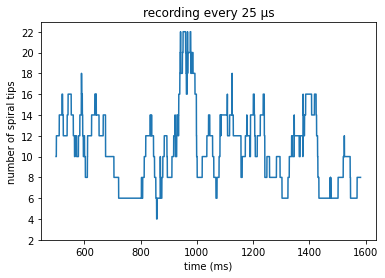

In [53]:
x_values = t_list
y_values = n_list

num_observations = len(x_values)
print(num_observations)

save = True
plt.plot(x_values,y_values)
plt.title(f"recording every 25 µs")
plt.xlabel(f"time (ms)")
plt.ylabel(f"number of spiral tips")
# ax.set_xticks([])
plt.yticks([2,4,6,8,10,12,14,16,18,20,22])
if not save:
    plt.show()
else:
    os.chdir(nb_dir)
    os.chdir('Figures/methods')
    plt.savefig(f"example_ic_200x200.120.32_num_tips_t_0_{t:.1}_V_{V_threshold}.png")
    #     plt.savefig('example_no_high_frequency_birth_deaths_t_500_600.png')

In [49]:
df = pd.DataFrame({'t':x_values,'n':y_values})
df.to_csv(f"example_birth_deaths_V_{V_threshold}_ic_200x200.120.32_t_0_{t:.1}.csv", index=False)

# pd.DataFrame({'t':x_values,'n':y_values}).to_csv('example_no_high_frequency_birth_deaths_t_500_600.csv', index=False)


In [50]:
# df.query('t>=506.8748 and t<=506.8752').index
t

1582.1000000015538

In [51]:
boo = df.n.diff().values==1
print('odd births occured at')
print(df[boo].t.values)

boo = df.n.diff().values==-1
print('odd deaths occured at')
print(df[boo].t.values)

odd births occured at
[]
odd deaths occured at
[]


In [111]:
print('sampling frequency must be lower than the following to resolve high freq. bdrates (ms):')
print(526.975-525.125)
print(593.425-592.)

sampling frequency must be lower than the following to resolve high freq. bdrates (ms):
1.8500000000000227
1.4249999999999545


^this suggests I should record at a rate of less then 526.975-525.125 ~ 1.5 ms to ensure two births aren't misinterpretted as a quadruplet birth.

# DONE: debugged _bring_vertices_together for a jump accross pbc.  Solving a tip that shouldn't be there but is.

In [305]:
# #compute the images to find isosurfaces of
# img    = pad_mat_by_1x1(txt[...,0])
# dimgdt = pad_mat_by_1x1(dtexture_dt[...,0])

# #compute both families of contours
# contours1 = find_contours(img,    level = 0.5)
# contours2 = find_contours(dimgdt, level = 0.0)

# #find_tips
# n_lst, x_lst, y_lst = contours_to_simple_tips_pbc(contours1,contours2,width, height,jump_threshold = 2,size_threshold = 6)
# n_tips = count_tips(x_lst)

# print(n_tips)


12


In [403]:
# # parse tips
# num_tips = count_tips(x_lst)
# x_values = np.array(flatten(x_lst))
# y_values = np.array(flatten(y_lst))

The high frequency tip is on the bottom boundary of the domain. It looks like it happens on red speckles belonging to contours2.  It does not appear to be anywhere near contours1.
- last lst index position has the erroneous pair at x=66.0 and y=200.0.

In [405]:
# y_bad = np.mean(y_lst[-1])
# x_bad = np.mean(x_lst[-1])
# print(f'the bad intersections occur at {y_bad,x_bad} with the (0,0) contours in contour12_lst_lst.')

In [327]:
# n_lst[-1]

(0, 0)

In [406]:
# contours1[0]

In [407]:
# contours2[0]

In [333]:
#it looks like contour1 and contour2 jump accross the map and cross at this location.  
# ^this implies theres a bug in the contour augmentation.

In [409]:
# #compute the images to find isosurfaces of
# img    = pad_mat_by_1x1(txt[...,0])
# dimgdt = pad_mat_by_1x1(dtexture_dt[...,0])

#compute both families of contours
contours1 = find_contours(img,    level = 0.5)
contours2 = find_contours(dimgdt, level = 0.0)

#find_tips
n_lst, x_lst, y_lst = contours_to_simple_tips_pbc(contours1,contours2,width, height,jump_threshold = 2,size_threshold = 6)
n_tips = count_tips(x_lst)

print(n_tips)

10


In [410]:
# #segment and augment contours of the first family
# contour1_lst_lst = []
# for contour in contours1:
#     if len(contour) >= size_threshold:
#         contour1_lst = split_and_augment_contour_into_contiguous_segments(contour, width, height, threshold=jump_threshold)
#         contour1_lst_lst.append(contour1_lst)
# #segment and augment contours of the second family
# contour2_lst_lst = []
# for contour in contours2:
#     if len(contour) >= size_threshold:
#         contour2_lst = split_and_augment_contour_into_contiguous_segments(contour, width, height, threshold=jump_threshold)
#         contour2_lst_lst.append(contour2_lst)

# #detect tips as above. Print tip number as above
# n_lst, x_lst, y_lst = find_tips(contour1_lst_lst, contour2_lst_lst)
# count_tips(x_lst)

In [411]:
# contour1_lst_bad = contour1_lst_lst[0]
# contour2_lst_bad = contour2_lst_lst[0]

In [412]:
# #print last two points of each contour
# for ct in contour1_lst_bad:
#     print(ct[-2:])#ct[:2] first two

In [413]:
# #print last two points of each contour
# for ct in contour2_lst_bad:
#     print(ct[-2:])#ct[:2] first two

In [414]:
# #this contour1 has a mistake at the end
# x1, y1 = contour1_lst_bad[-2].T
# x2, y2 = contour2_lst_bad[1].T

# #do they yield an intersection
# foundybad, foundxbad = intersection(x1,y1,x2,y2)#[0]#.size

In [415]:
# print( np.mean(foundxbad) ) 
# print (x_bad ) 

- I found the offending contour data that generated the false spiral tip.
- contour1_lst_bad[-2] looks like it was augmented by two vertices, where the second one was an error.
- I updated _bring_vertices_together to update dist after updating vmove.  This solved the problem.

In [399]:
# contour1_lst_bad[-2]

# (DONE: debugging) print the repeatable frames where +1 or -1 birth-deaths occurred. These must be errors

In [99]:
x_values = t_list
y_values = n_list
df = pd.DataFrame({'t':x_values,'n':y_values})
# df.to_csv(f"example_no_high_frequency_birth_deaths_ic_200x200.120.32_t_0_{t:.1}.csv", index=False)


In [100]:
#were odd tips observed after 100 ms? Yes...
boo = (df.query('t>1000').n%2!=0).values
percent_of_obs_w_odd_tips = 100*df.query('t>1000')[boo].n.size/df.query('t>1000').n.size
percent_of_obs_w_odd_tips

4.558125

In [103]:
# print(df.query('t>1000')[boo].query('n==7').n.values)
# (df.query('t>500').n.diff().dropna().values%2!=0)
df['dn'] = df.n.diff()
set(df.query('t>500').n.diff().dropna().values)

{-4.0, -2.0, -1.0, 0.0, 1.0, 2.0}

In [111]:
print('the first 10 1-births after t=500 occur at times:')
boo = df['dn']==1
df[boo].query('t>500').t.values[:10]

the first 10 1-births after t=500 occur at times:


array([506.875, 525.125, 525.275, 558.425, 592.925, 607.075, 659.975,
       663.025, 667.075, 673.625])

In [109]:
print('the first 10 1-deaths after t=500 occur at times:')
boo = df['dn']==-1
df[boo].query('t>500').t.values[:10]

the first 10 1-deaths after t=500 occur at times:


array([506.05 , 556.625, 592.675, 604.975, 659.525, 660.15 , 666.375,
       673.05 , 734.475, 776.9  ])

TODO: isolate the first birth death pair at times t=506.875 ms (birth, then 525.125, 525.275) and t=506.05 ms (death, then 556.625, 592.675)

In [450]:
# file = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-1/ic-out/ic_200x200.120.32.npz'
# txt = load_buffer(file)
# t   = 0. #ms

#load ^that loaded initial after 20000 steps = 500 ms at time_steps of size 0.025
file = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/test_txt.npz'
txt  = load_buffer(file)
t   = 500 #ms

t_list = []
n_list = []   

In [451]:
zero_txt = txt.copy()*0.
width, height = txt.shape[:2]

h    = 0.025 #ms
tmax = 510#506.05#500# #ms

while t<tmax:
    #compute as discrete flow map dtexture_dt
    dtexture_dt = zero_txt.copy()
    get_time_step(txt, dtexture_dt)

    #compute the images to find isosurfaces of
    img    = txt[...,0]
    dimgdt = dtexture_dt[...,0]
    
    #compute both families of contours
    contours1 = find_contours(img,    level = 0.5)
    contours2 = find_contours(dimgdt, level = 0.0)

    #find_tips
    n_lst, x_lst, y_lst = contours_to_simple_tips_pbc(contours1,contours2,width, height, jump_threshold = 2, size_threshold = 6)
    s1_values, s2_values, x_values, y_values = unwrap_and_reduce_tips(n_lst, x_lst, y_lst, width, height, pad=1)
    n_tips = count_tips(x_values)

    #record data for current time
    t_list.append(t)
    n_list.append(n_tips)

    #forward Euler integration in time
    txt += h*dtexture_dt
    t   += h
beep(3)

0

In [ ]:
tt

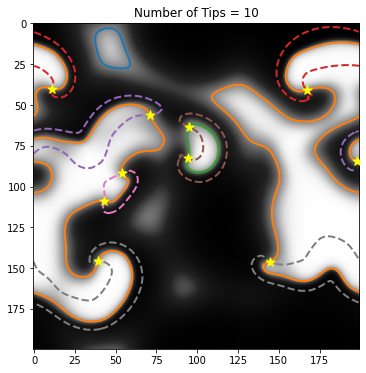

In [453]:
# Display the image and plot all pbc contours found properly!
save = False
fig, ax = plt.subplots(figsize=(6,6))
# fig, axs = plt.subplots(ncols = 2, figsize=(8,4))
# ax = axs[0]

contours1 = find_contours(img, level=0.5, mode='pbc')
ax.imshow(img, cmap=plt.cm.gray)
plot_contours_pbc(contours1, ax, linewidth=2, min_num_vertices=15, linestyle='-')

contours2 = find_contours(dimgdt, level=0.0, mode='pbc')
# ax.imshow(img, cmap=plt.cm.gray)
plot_contours_pbc(contours2, ax, linewidth=2, min_num_vertices=15, linestyle='--')

#parse tips
n_lst, x_lst, y_lst = contours_to_simple_tips_pbc(contours1,contours2,width, height, jump_threshold = 3, size_threshold = 7)
num_tips = count_tips(x_lst)
x_values = np.array(flatten(x_lst))
y_values = np.array(flatten(y_lst))
ax.scatter(x=x_values, y=y_values, s=90, c='yellow', marker='*', zorder=3, alpha=1.)

# axaxis([0,100,0,100])

ax.set_title(f"Number of Tips = {num_tips}")
ax.axis('image')
# ax.set_xticks([])
# ax.set_yticks([])

if not save:
    plt.show()
else:
    os.chdir(nb_dir)
    os.chdir('Figures/methods')
    plt.savefig(f"example_odd_tips_fixed_ic_200x200.120.32_t_{t:.1}.png")
    #     plt.savefig('example_parameterless_tip_detection_t_600.png')

__Problem spotted__ - there should be a spiral tip at x = 0,200 and y ~ 80, but there isn't.

In [354]:
# #TODO(ignore, pursueing this would only introduce bugs) find the first contour in contour_lst_lst with length>min_number_of_vertices
# min_number_of_vertices = 4
# boo = [len(ct)>min_number_of_vertices for ct in contour1_lst_lst]
# for n,ct in contour1_lst_lst if 
from lib.measure._utils_find_tips import *

## Solving a tip that should be there but isn't

In [165]:
#TODO: identify the contours at fault.
#TODO: identify if contours1 or contours2 is not obeying pbc
#TODO: reproduce that same contour error from functionally
#TODO: debug the function that generates spiral tip contours.


In [166]:
print(x_lst)

[[168.80338951730246], [145.0703048816391], [8.56864742820401], [42.23689367775604], [71.91106824515633, 53.7161315203534], [38.20100835095601], [94.955912765964, 94.13209638068882]]


In [167]:
print(y_lst)

[[40.412421348190485], [145.68375414431742], [39.43380346468959], [108.773016787919], [57.28526861122329, 91.4533257447881], [148.0346182920922], [80.50721898582722, 65.13553113519737]]


the only knot that has three spiral tips is the 5th knot.  First, split the raw contours into the correct lists of lists.

In [168]:
n_lst[4]

(1, 1)

In [169]:
# def preprocess_contours(contours1,contours2,width, height,jump_threshold = 2,size_threshold = 6):
#     #segment and augment contours of the first family
#     contour1_lst_lst = []
#     for contour in contours1:
#         if len(contour) >= size_threshold:
#             contour1_lst = split_and_augment_contour_into_contiguous_segments(contour, width, height, threshold=jump_threshold)
#             contour1_lst_lst.append(contour1_lst)
#     #segment and augment contours of the second family
#     contour2_lst_lst = []
#     for contour in contours2:
#         if len(contour) >= size_threshold:
#             contour2_lst = split_and_augment_contour_into_contiguous_segments(contour, width, height, threshold=jump_threshold)
#             contour2_lst_lst.append(contour2_lst)
#     return contour1_lst_lst, contour2_lst_lst

In [117]:
contour1_lst_lst, contour2_lst_lst = preprocess_contours(contours1, contours2, width, height, jump_threshold = 2, size_threshold = 6)

n_lst, x_lst, y_lst = find_tips(contour1_lst_lst, contour2_lst_lst)

n_tips = count_tips(x_lst)
print(n_tips)

TODO: look for which contiguous contours have contour2_lst_lst[n] start/end at 0 or 200

In [73]:
n=0
ct = contour1_lst_lst[1][n]
print(ct[:2])
print(ct[-2:])
print(len(ct))

[[179.05981928  39.        ]
 [179.2825803   38.        ]]
[[162.           0.3684674 ]
 [161.82428825   0.        ]]
58


In [76]:
# n=0
# n=1
n=1
# n=3
#nope n=4
ct = contour2_lst_lst[1][n]
print(ct[:2])
ct = contour2_lst_lst[1][n+1]
print(ct[-2:])
print(len(ct))

[[ 90.87825672 200.        ]
 [ 90.02431087 199.        ]]
[[114.          47.74644358]
 [114.45401016  47.        ]]
242


# DONE: try always augmenting on the bottom/right side and seeing if the problem persists.
- easiest way to do this is?
    - to add a segment on both ends during contour detection? no...
    - always map/augment contour on the right boundary and/or the bottom boundary

In [69]:
# from lib.measure._utils_find_contours import *

In [326]:
# def _bring_vertices_together(vmove, vtarget, width, height):
#     '''bring 2D vertex vmove as close as possible to 2D vertex 
#     vtarget by increasing xy coordinates by width or height to decrease the distance from vmove to vtarget.'''
#     vw = np.array([width,0.])
#     vh = np.array([0.,height])
#     dist = np.linalg.norm(vmove-vtarget)
#     vtest = vmove + vw
#     dist_test = np.linalg.norm(vtest-vtarget)
#     if dist_test < dist:
#         vmove = vtest.copy()
#         dist = dist_test.copy()
#     #     else:
#     #         vtest = vmove - vw
#     #         dist_test = np.linalg.norm(vtest-vtarget)
#     #         if dist_test < dist:
#     #             vmove = vtest.copy()
#     #             dist = np.linalg.norm(vmove-vtarget)
#     vtest = vmove + vh
#     dist_test = np.linalg.norm(vtest-vtarget)
#     if dist_test < dist:
#         vmove = vtest.copy()
#     #         dist = dist_test.copy()
#     #     else:
#     #         vtest = vmove - vh
#     #         dist_test = np.linalg.norm(vtest-vtarget)
#     #         if dist_test < dist:
#     #             vmove = vtest.copy()
#     #             #dist = np.linalg.norm(vmove-vtarget)
#     return vmove

In [343]:
# def split_and_augment_contour_into_contiguous_segments(contour, width, height, threshold=2):
#     '''returns a list of contiguous contours with one contour vertex added from across the computational domain, mapped onto the local coordinates. 
#     jump_threshold = the max number of pixels two points may be separated by to be considered contiguous.
#     size_threshold = the min number of vertices in a pbc contour
#     split the contour into a contour_lst of contiguous contours.
#     the last contour may have length 1 or 0.  simply ignore those later.'''
    
#     mask = get_contiguous_mask(contour, threshold=jump_threshold)
#     if mask.all():
#         #the contour is contiguous, no augmentation necessary.  Return the input contour as a list of one contour segment
#         return [contour]
#     else:
#         #the contour is not contiguous, jumps occured accross boundary
#         indices = np.nonzero(~mask)[0]+1
#         contour_lst = np.split(contour,indices)

#         #augment contours for each jump that occurred
#         N = len(contour_lst)
#         #for each jump, n
#         for n in range(N): 
#             ct_before       = contour_lst[n] #before jump
#             if n<N-1: #this checks for a jump at the end/beginning of the pbc contour.  This shouldn't be used when the final vertex equals the initial vertex.
#                 ct_after       = contour_lst[n+1] #after jump
#             else:
#                 ct_after       = contour_lst[0]
#             vend     = ct_before[-1]
#             vstart   = ct_after[0]
#             if vend.sum()>vstart.sum():
#                 #map vstart right and/or down to meet vend, appending to ct_before
#                 vmove=vstart
#                 vtarget=vend
#                 vmapped = _bring_vertices_together(vmove, vtarget, width=width, height=height)
#                 #append the mapped vstart to vend
#                 print( f"Check {vmove} correctly moved to {vmapped} to meet {vtarget}.")
#                 #if vmapped is not exactly on top of vtarget
#                 if ~(vmapped==vtarget).all(): #this check makes the results robust to repeated application or inputs that are already augmented
#                     #then augment that contour with the mapped vertex
#                     contour_lst[n] = np.vstack([ct_before,vmapped])
#             else:
#                 #map vend right and/or down to meet vstart, prepending to ct_after
#                 vmove=vend
#                 vtarget=vstart
#                 vmapped = _bring_vertices_together(vmove, vtarget, width=width, height=height)
#                 #append the mapped vstart to vend
#                 #if vmapped is not exactly on top of vtarget
#                 if ~(vmapped==vtarget).all(): #this check makes the results robust to repeated application or inputs that are already augmented
#                     print( f"Check {vmove} correctly moved to {vmapped} to meet {vtarget}.")
#                     #then augment that contour with the mapped vertex
#                     if n<N-1: #this checks for a jump at the end/beginning of the pbc contour.  This shouldn't be used when the final vertex equals the initial vertex.
#                         contour_lst[n+1] = np.vstack([vmapped, ct_after])
#                     else:
#                         contour_lst[0] = np.vstack([vmapped, ct_after])
#         return contour_lst

In [356]:
# def preprocess_contours(contours1,contours2,width, height,jump_threshold = 2,size_threshold = 6):
#     #segment and augment contours of the first family
#     contour1_lst_lst = []
#     for contour in contours1:
#         if len(contour) >= size_threshold:
#             contour1_lst = split_and_augment_contour_into_contiguous_segments(contour, width, height, threshold=jump_threshold)
#             contour1_lst_lst.append(contour1_lst)
#     #segment and augment contours of the second family
#     contour2_lst_lst = []
#     for contour in contours2:
#         if len(contour) >= size_threshold:
#             contour2_lst = split_and_augment_contour_into_contiguous_segments(contour, width, height, threshold=jump_threshold)
#             contour2_lst_lst.append(contour2_lst)
#     return contour1_lst_lst, contour2_lst_lst

contour1_lst_lst, contour2_lst_lst = preprocess_contours(contours1,contours2,width, height,jump_threshold = 2,size_threshold = 6)

(ignore) Maybe another problem is the periodic boundary conditions aren't being explicitly enforced  at jumps.  

DONE: ^this can be checked by 
- DONE computing the L2 distance between each pair of segments in the pbc contour
- DONE if any distances lie between 3-197, then the segments aren't being mapped to eachother properly

(ignore) ^if ^this is indeed a problem, ^this can be fixed by introducing my previous L2_pbc metric  into the function that collects segments into contours, _assemble_contours(segments).

_confirmed not a problem_: all segments have distances that are either closer than 3 pixels or further than 197 pixels, but not further than 200 pixels.

^this supports the right mapping accross the boundary.  This makes sense because of segments are the fundamental data element used in my contour finding method.

In [283]:
# print('test whether there are any distances in the given range')
# for contour in contours1:
#     dists = np.linalg.norm(np.diff(contour, axis=0), axis=-1)
#     boo = ((dists>3) & (dists>199))
#     print(dists[boo].size!=0)

In [282]:
# print('test whether there are any distances in the given range')
# for contour in contours2:
#     dists = np.linalg.norm(np.diff(contour, axis=0), axis=-1)
#     boo = ((dists>3) & (dists<200))
#     print(dists[boo].size!=0)

# it's still not working, try appending/prepending to both contour_before and contour_after

# (before ^that) check that the contour is actually periodic

In [77]:
# determine the number of tips in each contour
x_lst

[[169.08916818816826],
 [145.2020212253846],
 [8.144426027355838],
 [42.089877835908055],
 [72.16917871998079, 53.71630066059521],
 [38.024505213944956],
 [94.95987657346976, 93.97919908374608]]

In [64]:
n_lst

[(1, 0), (1, 3), (1, 0), (1, 1), (1, 1), (1, 3), (2, 2)]

In [80]:
# contour1_lst_lst[1]
contour = contour2_lst_lst[1]

In [449]:
# n=0
# k = 7
# # n=1nope
# print('end before jump')
# ct = contour[n]
# before = ct[-k:]
# print(before)
# ct = contour[n+1]
# print('*jump*')
# print('start after jump')
# after = ct[:k]
# print(after)
# print(len(ct))

# c_lst = list(range(k))

In [448]:
# plt.scatter(x=before[:,1],y=before[:,0],c=c_lst)
# plt.show()

In [447]:
# plt.scatter(x=after[:,1],y=after[:,0],c=c_lst)
# plt.show()

In [128]:
# def _bring_vertices_together(vmove, vtarget, width, height):
#     '''bring 2D vertex vmove as close as possible to 2D vertex 
#     vtarget by increasing xy coordinates by width or height to decrease the distance from vmove to vtarget.'''
#     vw = np.array([width,0.])
#     vh = np.array([0.,height])
#     dist = np.linalg.norm(vmove-vtarget)
#     vtest = vmove + vw
#     dist_test = np.linalg.norm(vtest-vtarget)
#     if dist_test < dist:
#         vmove = vtest.copy()
#         dist = dist_test.copy()
#     else:
#         vtest = vmove - vw
#         dist_test = np.linalg.norm(vtest-vtarget)
#         if dist_test < dist:
#             vmove = vtest.copy()
#             dist = np.linalg.norm(vmove-vtarget)
#     vtest = vmove + vh
#     dist_test = np.linalg.norm(vtest-vtarget)
#     if dist_test < dist:
#         vmove = vtest.copy()
#         dist = dist_test.copy()
#     else:
#         vtest = vmove - vh
#         dist_test = np.linalg.norm(vtest-vtarget)
#         if dist_test < dist:
#             vmove = vtest.copy()
#             #dist = np.linalg.norm(vmove-vtarget)
#     return vmove

In [129]:
# def split_and_augment_contour_into_contiguous_segments(contour, width, height, threshold=2):
#     '''returns a list of contiguous contours with one contour vertex added from across the computational domain, mapped onto the local coordinates. 
#     jump_threshold = the max number of pixels two points may be separated by to be considered contiguous.
#     size_threshold = the min number of vertices in a pbc contour
#     split the contour into a contour_lst of contiguous contours.
#     the last contour may have length 1 or 0.  simply ignore those later.'''
#     mask = get_contiguous_mask(contour, threshold=threshold)
#     if mask.all():
#         #the contour is contiguous, no augmentation necessary.  Return the input contour as a list of one contour segment
#         return [contour]
#     else:
#         #the contour is not contiguous, jumps occured accross boundary
#         indices = np.nonzero(~mask)[0]+1
#         contour_lst = np.split(contour,indices)

#         #augment contours for each jump that occurred
#         N = len(contour_lst)
#         #for each jump, n
#         for n in range(N): 
#             ct_before       = contour_lst[n] #before jump
#             if n<N-1: #this checks for a jump at the end/beginning of the pbc contour.  This shouldn't be used when the final vertex equals the initial vertex.
#                 ct_after       = contour_lst[n+1] #after jump
#             else:
#                 ct_after       = contour_lst[0]
#             vend     = ct_before[-1]
#             vstart   = ct_after[0]
#             #map the start to the end and the end to the start
#             vmove=vstart
#             vtarget=vend
#             vmapped_end = _bring_vertices_together(vmove, vtarget, width=width, height=height)
#             vmove=vend
#             vtarget=vstart
#             vmapped_start = _bring_vertices_together(vmove, vtarget, width=width, height=height)
#             #add the new end to the end if it hasn't already
#             if ~(vmapped_end==vend).all():
#                 contour_lst[n] = np.vstack([ct_before,vmapped_end])
#             #add the new start to the start if it hasn't already
#             if ~(vmapped_start==vstart).all():
#                 if n<N-1: #this checks for a jump at the end/beginning of the pbc contour.  This shouldn't be used when the final vertex equals the initial vertex.
#                     contour_lst[n+1] = np.vstack([vmapped_start, ct_after])
#                 else:
#                     contour_lst[0] = np.vstack([vmapped_start, ct_after])
#         return contour_lst

# DONE: debug by removing redundant tips

10


In [140]:
x_lst

[[168.97691928458286],
 [145.15499221344024],
 [8.289892465488741],
 [-0.4972661837627513],
 [199.50273381623725],
 [42.14259352866384],
 [72.07522382704923, 53.71595936107701],
 [38.08553662040193],
 [94.95912994740634, 94.03363381197714]]

In [141]:
y_lst

[[40.37976285525308],
 [145.59907034020878],
 [39.40259370135202],
 [84.94671446988824],
 [84.94671446988824],
 [108.78883267605501],
 [57.459753154159586, 91.42288753829986],
 [148.32391159151007],
 [80.31144843202092, 65.30983240338988]]

In [142]:
n_lst

[(1, 0), (1, 7), (1, 0), (1, 2), (1, 2), (1, 2), (1, 2), (1, 7), (2, 3)]

In [144]:
#the tolerance for the mapped dimension is apparently 
-0.4972661837627513+199.50273381623725-199

0.00546763247450599

In [147]:
# the tolerance for the unmapped dimension is zero to machine precision
84.94671446988824 == 84.94671446988824

True

In [152]:
#best algorithm is to 
# - 1 - find the collection of spiral tips with matching coords for each dimension
# - 2 - for the other dimension, see if they differ by 199.0 ± 0.1 or 0.001
# - 3 - if so, remove it the smallest x+y coord from the list
#      find the first index of the 
#      use list().pop(index=index) for each n_lst, 

In [173]:
#step 1: determine if any such duplicate tips exist
x_values = flatten(x_lst)
y_values = flatten(y_lst)
duplicates_exist_in_x = len(x_values) != len(list(set(x_values)))
duplicates_exist_in_y = len(y_values) != len(list(set(y_values)))

In [174]:
#step 2: if duplicates exist in a given coord, identify the duplicate coord
if not (duplicates_exist_in_y | duplicates_exist_in_x):
    pass #no duplicates.  Continue
elif duplicates_exist_in_x:
    pass
elif duplicates_exist_in_y:
    pass

In [431]:
# def unwrap_tips(n_lst, x_lst, y_lst):
#     '''unwrap n_lst to s1_values and s2_values'''
#     s1_values = []
#     s2_values = []
#     for n,lst in enumerate(x_lst):
#         m = len(lst)
#         s1, s2 = n_lst[n]
#         s1_values.extend([s1 for j in range(m)])
#         s2_values.extend([s2 for j in range(m)])
#     x_values = flatten(x_lst)
#     y_values = flatten(y_lst)
#     return s1_values, s2_values, x_values, y_values

In [442]:
# def unwrap_and_reduce_tips(n_lst, x_lst, y_lst, width, height, pad=1):
#     '''returns s1_values, s2_values, x_values, y_values each as numpy arrays
#     unwrap_and_reduce_tips unwraps output of find_tips and then removes any tip duplicates if they are within distance pad of the boundary.
#     duplicate tips are identified by sharing an x or y coordinate that match to machine precision, 
#     i.e. are tips duplicated by periodic boundary conditions.  In the event of such a duplicate tip, 
#     the right/bottom tip is retained.
#     '''
#     #unwrap tips
#     s1_values, s2_values, x_values, y_values = unwrap_tips(n_lst, x_lst, y_lst)

#     #reduce redundant tips
#     # identify any duplicate values in that coord
#     boo_x = np.array([(x_values.count(x)-1)>0 for x in x_values])
#     boo_y = np.array([(y_values.count(y)-1)>0 for y in y_values])

#     s1_values=np.array(s1_values) 
#     s2_values=np.array(s2_values)
#     x_values =np.array(x_values)
#     y_values =np.array(y_values)

#     #step 1: determine if any such duplicate tips exist
#     duplicates_exist = boo_x.any() or boo_y.any()
#     if not duplicates_exist:
#         return s1_values, s2_values, x_values, y_values

#     #step 2: remove any tip duplicates in the x coordinates if they are within distance pad of the boundary
#     if boo_x.any():
#         #remove any tip duplicates in the x coordinates if they are within distance pad of the boundary
#         ar, index, inverse, counts = np.unique(x_values, return_index=True, return_inverse=True, return_counts=True,)
#         # #test that the inverse map reconstructs the original data
#         # assert ( (ar[inverse]-x_values == 0.).all() ) 
#         # #test that the forward map, index constructs the unique data
#         # assert ( (ar - x_values[index] == 0.).all() ) 

#         indices_to_be_appended = []
#         for j in index[counts>1]: 
#             #get the value that corresponds to this count>1 instance is x_values[j]
#             #get the original indices that correspond to this count>1 instance
#             boo = x_values[j]==x_values
#             #indices_to_be_appended at the end are those that lie in the bulk but still have a matching coordinate. The parameter pad controls this.
#             #the index of any duplicate values that should not be eliminated because they lie outside a number of pixels = pad of the boundary
#             indices_to_be_appended.extend(list(np.argwhere(boo & ( y_values > pad ) &  ( y_values < height-pad )).flatten()))
#             #index to replace the one given
#             i = int(np.argwhere(boo & ( y_values >= height-pad )).flatten())
#         #append indices_to_be_appended, if any
#         index = list(index)
#         index.extend(indices_to_be_appended)

#         #recompute the unwrapped tips, now guaranteed to be unique in this coordinate
#         x_values = x_values[index]
#         y_values = y_values[index]
#         s1_values = s1_values[index]
#         s2_values = s2_values[index]

#         boo_y = np.array([(list(y_values).count(y)-1)>0 for y in y_values])

#     #step 3: remove any tip duplicates in the y coordinates if they are within distance pad of the boundary
#     if boo_y.any():
#         ar, index, inverse, counts = np.unique(y_values, return_index=True, return_inverse=True, return_counts=True,)
#         # #test that the inverse map reconstructs the original data
#         # assert ( (ar[inverse]-y_values == 0.).all() ) 
#         # #test that the forward map, index constructs the unique data
#         # assert ( (ar - y_values[index] == 0.).all() ) 

#         indices_to_be_appended = []
#         for j in index[counts>1]: 
#             #get the value that corresponds to this count>1 instance is y_values[j]
#             #get the original indices that correspond to this count>1 instance
#             boo = y_values[j]==y_values

#             #indices_to_be_appended at the end are those that lie in the bulk but still have a matching coordinate. The parameter pad controls this.
#             #the index of any duplicate values that should not be eliminated because they lie outside a number of pixels = pad of the boundary
#             indices_to_be_appended.extend(list(np.argwhere(boo & ( x_values > pad ) &  ( x_values < width-pad )).flatten()))
#             #index to replace the one given
#             i = int(np.argwhere(boo & ( x_values >= width-pad )).flatten())
#         #append indices_to_be_appended, if any
#         index = list(index)
#         index.extend(indices_to_be_appended)

#         #recompute the unwrapped tips, now guaranteed to be unique in this coordinate
#         x_values = x_values[index]
#         y_values = y_values[index]
#         s1_values = s1_values[index]
#         s2_values = s2_values[index]
#     return s1_values, s2_values, x_values, y_values

10

10

In [346]:
# inverse[index]
index[inverse]

array([ 0,  1,  2,  3,  3,  5,  6,  7,  8,  9, 10])

[]

array([  8.28989247, 168.97691928,  72.07522383,  94.03363381,
        94.95912995, 199.50273382,  53.71595936,  42.14259353,
       145.15499221,  38.08553662])

In [397]:
#find the index of any exceptions
lst

[]

In [378]:
#append those to list



In [330]:
# update index with i at j
index

array([ 2,  0,  6, 10,  9,  3,  7,  5,  1,  8])

In [291]:
y_values[j]
y_values[j]

84.94671446988824

In [282]:
#identify each match
for i in np.argwhere(counts-1>0).flatten():
    print(i)# new_index of match
    

5


In [64]:
img    = txt[...,0]
dimgdt = dtexture_dt[...,0]

contours1 = find_contours(img, level=0.5, mode='pbc')
contours2 = find_contours(dimgdt, level=0.0, mode='pbc')

n_lst, x_lst, y_lst = contours_to_simple_tips_pbc(contours1,contours2,width, height, jump_threshold = 3, size_threshold = 6)
s1_values, s2_values, x_values, y_values = unwrap_and_reduce_tips(n_lst, x_lst, y_lst, width, height, pad=3, decimals=11)
n_tips = count_tips(x_values)
print(n_tips)

10


In [45]:
# import inspect
# print(inspect.getsource(unwrap_and_reduce_tips))

In [54]:
print(x_values)
print(y_values)

[168.90031805 145.11732839   8.41128085  -0.573259   199.426741
  42.18464766  72.00205159  53.71593342  38.13599305  94.9579939
  94.07797934]
[ 40.3938423  145.63744437  39.41586996  84.91933212  84.91933212
 108.78142739  57.38317817  91.43628543 148.19835586  80.39771641
  65.23353223]


In [63]:
# def unwrap_and_reduce_tips(n_lst, x_lst, y_lst, width, height, pad=1, decimals=11):
#     '''returns s1_values, s2_values, x_values, y_values each as numpy arrays
#     unwrap_and_reduce_tips unwraps output of find_tips and then removes any tip duplicates if they are within distance pad of the boundary.
#     duplicate tips are identified by sharing an x or y coordinate that match to machine precision, 
#     i.e. are tips duplicated by periodic boundary conditions.  In the event of such a duplicate tip, 
#     the right/bottom tip is retained.
#     '''
#     #unwrap tips
#     s1_values, s2_values, x_values, y_values = unwrap_tips(n_lst, x_lst, y_lst)

#     #reduce redundant tips
#     # identify any duplicate values in each coord
#     x_values_rounded = np.around(x_values, decimals=decimals)
#     y_values_rounded = np.around(y_values, decimals=decimals)
#     boo_x = np.array([(list(x_values_rounded).count(x)-1)>0 for x in x_values_rounded])
#     boo_y = np.array([(list(y_values_rounded).count(y)-1)>0 for y in y_values_rounded])

#     s1_values=np.array(s1_values) 
#     s2_values=np.array(s2_values)
#     x_values =np.array(x_values)
#     y_values =np.array(y_values)

#     #step 1: determine if any such duplicate tips exist
#     duplicates_exist = boo_x.any() or boo_y.any()
#     if not duplicates_exist:
#         return s1_values, s2_values, x_values, y_values

#     #step 2: remove any tip duplicates in the x coordinates if they are within distance pad of the boundary
#     if boo_x.any():
#         #remove any tip duplicates in the x coordinates if they are within distance pad of the boundary
#         ar, index, inverse, counts = np.unique(x_values_rounded, return_index=True, return_inverse=True, return_counts=True,)
#         # #test that the inverse map reconstructs the original data
#         # assert ( (ar[inverse]-x_values_rounded == 0.).all() ) 
#         # #test that the forward map, index constructs the unique data
#         # assert ( (ar - x_values_rounded[index] == 0.).all() ) 

#         indices_to_be_appended = []
#         for j in index[counts>1]: 
#             #get the value that corresponds to this count>1 instance is x_values[j]
#             #get the original indices that correspond to this count>1 instance
#             boo = x_values_rounded[j]==x_values_rounded
#             #indices_to_be_appended at the end are those that lie in the bulk but still have a matching coordinate. The parameter pad controls this.
#             #the index of any duplicate values that should not be eliminated because they lie outside a number of pixels = pad of the boundary
#             indices_to_be_appended.extend(list(np.argwhere(boo & ( y_values > pad ) &  ( y_values < height-pad )).flatten()))
#             #index to replace the one given
#             i = int(np.argwhere(boo & ( y_values >= height-pad )).flatten())
#         #append indices_to_be_appended, if any
#         index = list(index)
#         index.extend(indices_to_be_appended)

#         #recompute the unwrapped tips, now guaranteed to be unique in this coordinate
#         x_values = x_values[index]
#         y_values = y_values[index]
#         s1_values = s1_values[index]
#         s2_values = s2_values[index]

#         y_values_rounded = np.around(y_values, decimals=decimals)
#         boo_y = np.array([(list(y_values_rounded).count(y)-1)>0 for y in y_values_rounded])

#     #step 3: remove any tip duplicates in the y coordinates if they are within distance pad of the boundary
#     if boo_y.any():

#         ar, index, inverse, counts = np.unique(y_values_rounded, return_index=True, return_inverse=True, return_counts=True,)
#         # #test that the inverse map reconstructs the original data
#         # assert ( (ar[inverse]-y_values_rounded == 0.).all() ) 
#         # #test that the forward map, index constructs the unique data
#         # assert ( (ar - y_values_rounded[index] == 0.).all() ) 

#         indices_to_be_appended = []
#         for j in index[counts>1]: 
#             #get the value that corresponds to this count>1 instance is y_values[j]
#             #get the original indices that correspond to this count>1 instance
#             boo = y_values_rounded[j]==y_values_rounded

#             #indices_to_be_appended at the end are those that lie in the bulk but still have a matching coordinate. The parameter pad controls this.
#             #the index of any duplicate values that should not be eliminated because they lie outside a number of pixels = pad of the boundary
#             indices_to_be_appended.extend(list(np.argwhere(boo & ( x_values > pad ) &  ( x_values < width-pad )).flatten()))
#             #index to replace the one given
#             i = int(np.argwhere(boo & ( x_values >= width-pad )).flatten())
#         #append indices_to_be_appended, if any
#         index = list(index)
#         index.extend(indices_to_be_appended)

#         #recompute the unwrapped tips, now guaranteed to be unique in this coordinate
#         x_values = x_values[index]
#         y_values = y_values[index]
#         s1_values = s1_values[index]
#         s2_values = s2_values[index]
#     return s1_values, s2_values, x_values, y_values

In [62]:
count_tips(x_values)

10

In [59]:
boo_x.any()

False